In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import optuna
import warnings
from sklearn.utils import all_estimators
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV, Ridge
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(logging.WARNING)
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [28]:
df = pd.read_csv('final_datasets/enhanced_anxiety_dataset.csv')
# df = pd.read_csv('cleaned_enhanced_anxiety_dataset.csv')
target_column = 'Anxiety Level (1-10)'

print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
print("Target column:", target_column)

Total rows: 11000
Total columns: 19
Target column: Anxiety Level (1-10)


In [134]:
len(df[df['Anxiety Level (1-10)']==6])

616

In [29]:
df_2 = df.copy()

In [30]:
df.dtypes

Age                                    int64
Gender                                object
Occupation                            object
Sleep Hours                          float64
Physical Activity (hrs/week)         float64
Caffeine Intake (mg/day)               int64
Alcohol Consumption (drinks/week)      int64
Smoking                               object
Family History of Anxiety             object
Stress Level (1-10)                    int64
Heart Rate (bpm)                       int64
Breathing Rate (breaths/min)           int64
Sweating Level (1-5)                   int64
Dizziness                             object
Medication                            object
Therapy Sessions (per month)           int64
Recent Major Life Event               object
Diet Quality (1-10)                    int64
Anxiety Level (1-10)                 float64
dtype: object

In [31]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Закодовано {col}: {len(le.classes_)} унікальних значень")

Закодовано Gender: 3 унікальних значень
Закодовано Occupation: 13 унікальних значень
Закодовано Smoking: 2 унікальних значень
Закодовано Family History of Anxiety: 2 унікальних значень
Закодовано Dizziness: 2 унікальних значень
Закодовано Medication: 2 унікальних значень
Закодовано Recent Major Life Event: 2 унікальних значень


In [32]:
df_encoded.dtypes

Age                                    int64
Gender                                 int64
Occupation                             int64
Sleep Hours                          float64
Physical Activity (hrs/week)         float64
Caffeine Intake (mg/day)               int64
Alcohol Consumption (drinks/week)      int64
Smoking                                int64
Family History of Anxiety              int64
Stress Level (1-10)                    int64
Heart Rate (bpm)                       int64
Breathing Rate (breaths/min)           int64
Sweating Level (1-5)                   int64
Dizziness                              int64
Medication                             int64
Therapy Sessions (per month)           int64
Recent Major Life Event                int64
Diet Quality (1-10)                    int64
Anxiety Level (1-10)                 float64
dtype: object

In [33]:
numeric_cols = df_encoded.select_dtypes(include='number').columns.tolist()
numeric_cols

['Age',
 'Gender',
 'Occupation',
 'Sleep Hours',
 'Physical Activity (hrs/week)',
 'Caffeine Intake (mg/day)',
 'Alcohol Consumption (drinks/week)',
 'Smoking',
 'Family History of Anxiety',
 'Stress Level (1-10)',
 'Heart Rate (bpm)',
 'Breathing Rate (breaths/min)',
 'Sweating Level (1-5)',
 'Dizziness',
 'Medication',
 'Therapy Sessions (per month)',
 'Recent Major Life Event',
 'Diet Quality (1-10)',
 'Anxiety Level (1-10)']

In [34]:
numeric_cols = df_encoded.select_dtypes(include='number').columns
numeric_cols = numeric_cols.drop(target_column, errors='ignore')
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("Масштабування числових ознак завершено")
print(f"Середнє значення після масштабування:\n{df_encoded[numeric_cols].mean()}")
print(f"\nСтандартне відхилення після масштабування:\n{df_encoded[numeric_cols].std()}")

Масштабування числових ознак завершено
Середнє значення після масштабування:
Age                                 -1.395248e-16
Gender                              -3.972580e-17
Occupation                           6.330290e-17
Sleep Hours                         -1.007679e-16
Physical Activity (hrs/week)        -7.363807e-17
Caffeine Intake (mg/day)             1.740830e-16
Alcohol Consumption (drinks/week)   -1.085193e-16
Smoking                             -6.459479e-18
Family History of Anxiety            6.104208e-17
Stress Level (1-10)                 -3.681903e-17
Heart Rate (bpm)                     1.847411e-16
Breathing Rate (breaths/min)         2.280196e-16
Sweating Level (1-5)                -1.508288e-16
Dizziness                           -1.395248e-16
Medication                           5.684342e-17
Therapy Sessions (per month)         5.684342e-17
Recent Major Life Event             -9.172461e-17
Diet Quality (1-10)                  2.906766e-17
dtype: float64

Стандар

In [35]:
numeric_cols

Index(['Age', 'Gender', 'Occupation', 'Sleep Hours',
       'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)',
       'Alcohol Consumption (drinks/week)', 'Smoking',
       'Family History of Anxiety', 'Stress Level (1-10)', 'Heart Rate (bpm)',
       'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Dizziness',
       'Medication', 'Therapy Sessions (per month)', 'Recent Major Life Event',
       'Diet Quality (1-10)'],
      dtype='object')

In [36]:
df_encoded.dtypes

Age                                  float64
Gender                               float64
Occupation                           float64
Sleep Hours                          float64
Physical Activity (hrs/week)         float64
Caffeine Intake (mg/day)             float64
Alcohol Consumption (drinks/week)    float64
Smoking                              float64
Family History of Anxiety            float64
Stress Level (1-10)                  float64
Heart Rate (bpm)                     float64
Breathing Rate (breaths/min)         float64
Sweating Level (1-5)                 float64
Dizziness                            float64
Medication                           float64
Therapy Sessions (per month)         float64
Recent Major Life Event              float64
Diet Quality (1-10)                  float64
Anxiety Level (1-10)                 float64
dtype: object

In [37]:
df_encoded

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,-0.849359,-1.211023,-1.597525,-0.530115,-0.132478,-0.725727,0.052442,0.950496,-1.065213,1.415627,1.332415,-1.348395,0.657245,-1.031777,0.970260,0.262107,0.977881,0.628018,5.0
1,0.435061,1.237062,0.539177,-0.367176,1.508891,-0.594517,-0.299086,0.950496,0.938779,-1.659122,-1.669040,0.395834,-0.772538,0.969201,-1.030651,-0.195977,-1.022619,0.973428,3.0
2,1.795036,0.013019,0.806265,-1.344810,0.414645,-1.167696,-1.002141,-1.052082,0.938779,-1.659122,0.004849,1.364850,-0.057646,-1.031777,-1.030651,-0.654060,0.977881,-1.444441,1.0
3,-1.529347,-1.211023,1.073353,-0.693054,-0.077766,0.510405,-0.650614,0.950496,-1.065213,-0.634206,-0.283753,-0.766985,-0.057646,-1.031777,-1.030651,-1.112144,-1.022619,-1.444441,2.0
4,0.661724,-1.211023,0.806265,1.262214,-0.351328,-0.269946,-1.002141,0.950496,-1.065213,-1.659122,0.408890,-0.379379,0.657245,0.969201,0.970260,-0.654060,-1.022619,-0.753622,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,-1.302684,-1.211023,-0.529174,-0.448645,0.086371,1.932992,-0.123322,0.950496,-1.065213,0.732349,0.004849,1.364850,-1.487429,0.969201,0.970260,-0.654060,-1.022619,-0.753622,6.0
10996,0.737278,1.237062,1.607528,-0.041298,0.359932,-1.533701,1.282788,0.950496,-1.065213,0.390710,0.235730,-0.766985,-0.057646,-1.031777,-1.030651,-0.195977,-1.022619,0.628018,3.0
10997,-0.849359,0.013019,0.539177,0.040172,2.165439,-0.877654,0.755497,-1.052082,-1.065213,0.732349,-1.091837,-0.960788,-1.487429,0.969201,0.970260,-0.195977,0.977881,0.628018,4.0
10998,0.963941,1.237062,-1.597525,-0.774523,-0.132478,-0.263041,-0.299086,-1.052082,-1.065213,-0.634206,1.216974,1.364850,-0.057646,0.969201,0.970260,-0.654060,0.977881,-1.099031,4.0


In [38]:
X = df_encoded.drop(columns=[target_column])
y = df_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")


Розмір тренувальної вибірки: (8800, 18)
Розмір тестової вибірки: (2200, 18)


In [39]:
df_encoded

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,-0.849359,-1.211023,-1.597525,-0.530115,-0.132478,-0.725727,0.052442,0.950496,-1.065213,1.415627,1.332415,-1.348395,0.657245,-1.031777,0.970260,0.262107,0.977881,0.628018,5.0
1,0.435061,1.237062,0.539177,-0.367176,1.508891,-0.594517,-0.299086,0.950496,0.938779,-1.659122,-1.669040,0.395834,-0.772538,0.969201,-1.030651,-0.195977,-1.022619,0.973428,3.0
2,1.795036,0.013019,0.806265,-1.344810,0.414645,-1.167696,-1.002141,-1.052082,0.938779,-1.659122,0.004849,1.364850,-0.057646,-1.031777,-1.030651,-0.654060,0.977881,-1.444441,1.0
3,-1.529347,-1.211023,1.073353,-0.693054,-0.077766,0.510405,-0.650614,0.950496,-1.065213,-0.634206,-0.283753,-0.766985,-0.057646,-1.031777,-1.030651,-1.112144,-1.022619,-1.444441,2.0
4,0.661724,-1.211023,0.806265,1.262214,-0.351328,-0.269946,-1.002141,0.950496,-1.065213,-1.659122,0.408890,-0.379379,0.657245,0.969201,0.970260,-0.654060,-1.022619,-0.753622,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,-1.302684,-1.211023,-0.529174,-0.448645,0.086371,1.932992,-0.123322,0.950496,-1.065213,0.732349,0.004849,1.364850,-1.487429,0.969201,0.970260,-0.654060,-1.022619,-0.753622,6.0
10996,0.737278,1.237062,1.607528,-0.041298,0.359932,-1.533701,1.282788,0.950496,-1.065213,0.390710,0.235730,-0.766985,-0.057646,-1.031777,-1.030651,-0.195977,-1.022619,0.628018,3.0
10997,-0.849359,0.013019,0.539177,0.040172,2.165439,-0.877654,0.755497,-1.052082,-1.065213,0.732349,-1.091837,-0.960788,-1.487429,0.969201,0.970260,-0.195977,0.977881,0.628018,4.0
10998,0.963941,1.237062,-1.597525,-0.774523,-0.132478,-0.263041,-0.299086,-1.052082,-1.065213,-0.634206,1.216974,1.364850,-0.057646,0.969201,0.970260,-0.654060,0.977881,-1.099031,4.0


In [40]:
classifiers = all_estimators(type_filter='regressor')
skip_models = ['GaussianProcessRegressor', 'QuantileRegressor'] 
results = {}

print(f"Тестування різних регресорів з кросвалідацією (5 фолдів)")
print("=" * 80)

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, RegressorClass in classifiers:
    if name in skip_models:
        continue 
    try:
        model = RegressorClass()
        scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        
        mape_scores = -scores 
        mean_mape = mape_scores.mean()
        std_mape = mape_scores.std()

        model.fit(X_train, y_train)
        
        r2 = np.nan
        try:
            y_pred = model.predict(X_train)
            r2 = r2_score(y_train, y_pred)
        except Exception:
            r2 = np.nan
            
        if not np.isnan(mean_mape):
            results[name] = {
                'mean_mape': mean_mape, 
                'std_dev': std_mape,
                'r2_score': r2          
            }
            print(f"{name}: MAPE {mean_mape:.2%} (± {std_mape:.2%}), R2 Score: {r2:.3f}")
        else:
            print(f"{name}: Пропущено через NaN у результаті") 

    except Exception as e:
        continue
       
sorted_results = sorted(results.items(), key=lambda x: x[1]['mean_mape'], reverse=False)

print("\nТоп-10 моделей з найменшою помилкою (MAPE):")
for i, (name, metric) in enumerate(sorted_results[:10], 1):
    print(f"{i:2d}. {name:40s} | MAPE: {metric['mean_mape']:.2%} (± {metric['std_dev']:.2%}) | R2: {metric['r2_score']:.3f}")
    
results_df = pd.DataFrame.from_dict(results, orient='index')

Тестування різних регресорів з кросвалідацією (5 фолдів)
ARDRegression: MAPE 32.30% (± 0.65%), R2 Score: 0.715
AdaBoostRegressor: MAPE 36.60% (± 0.59%), R2 Score: 0.733
BaggingRegressor: MAPE 32.59% (± 0.35%), R2 Score: 0.953
BayesianRidge: MAPE 32.33% (± 0.68%), R2 Score: 0.716
DecisionTreeRegressor: MAPE 40.80% (± 0.62%), R2 Score: 1.000
DummyRegressor: MAPE 60.93% (± 0.02%), R2 Score: 0.000
ElasticNet: MAPE 44.55% (± 0.25%), R2 Score: 0.463
ElasticNetCV: MAPE 32.32% (± 0.68%), R2 Score: 0.716
ExtraTreeRegressor: MAPE 40.90% (± 1.43%), R2 Score: 1.000
ExtraTreesRegressor: MAPE 31.65% (± 0.53%), R2 Score: 1.000
GammaRegressor: MAPE 38.53% (± 0.33%), R2 Score: 0.607
GradientBoostingRegressor: MAPE 30.87% (± 0.41%), R2 Score: 0.782
HistGradientBoostingRegressor: MAPE 31.14% (± 0.51%), R2 Score: 0.839
HuberRegressor: MAPE 32.07% (± 0.70%), R2 Score: 0.715
KNeighborsRegressor: MAPE 38.31% (± 1.06%), R2 Score: 0.779
KernelRidge: MAPE 126.52% (± 0.56%), R2 Score: -2.738
Lars: MAPE 32.32% (±

In [167]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import numpy as np
import pandas as pd

# --- Step 1: Generate Predictions from Base Models ---
base_model_predictions = {}
n_features = X_train.shape[1]

for name, RegressorClass in classifiers:
    if name in skip_models:
        continue
    
    try:
        # Check if the model needs n_components adjustment (e.g., PLS)
        # We ensure n_components does not exceed the number of features
        if hasattr(RegressorClass, 'n_components') or "PLS" in name:
            model = RegressorClass(n_components=min(1, n_features))
        else:
            model = RegressorClass()
            
        model.fit(X_train, y_train)
        predictions = model.predict(X_train)
        base_model_predictions[name] = predictions
    except Exception as e:
        print(f"Skipping {name} due to initialization/fit error: {e}")

# Convert to DataFrame
predictions_df = pd.DataFrame(base_model_predictions)

# --- Step 2: Correlation Analysis & Model Selection ---
correlation_matrix = predictions_df.corr()

print("Кореляція між прогнозами базових моделей:")
print(correlation_matrix)

selected_models = []
# If features are limited, correlation might be 1.0. 
# You might need to raise this threshold if selected_models is empty.
threshold = 0.9  

for name in correlation_matrix.columns:
    # Logic: Select models that aren't too highly correlated with others
    # (Note: With 1 feature, models often correlate highly; adjusting threshold to 0.9)
    other_models = correlation_matrix[name].drop(name)
    if all(abs(other_models) < threshold):
        selected_models.append(name)

# Fallback: if no models meet the criteria, just take the top 2 unique ones
if not selected_models and len(correlation_matrix.columns) >= 2:
    selected_models = list(correlation_matrix.columns[:2])
    print("\nWarning: No models met the threshold. Defaulting to first 2 models.")

print(f"\nОбрані моделі для стекінгу: {selected_models}")

# --- Step 3: Instantiate Selected Models ---

def instantiate_model(model_name):
    for name, RegressorClass in classifiers:
        if name == model_name:
            try:
                if hasattr(RegressorClass, 'n_components') or "PLS" in name:
                    return RegressorClass(n_components=min(1, n_features))
                return RegressorClass()
            except:
                return None
    return None

top_models = []
for name in selected_models:
    model_obj = instantiate_model(name)
    if model_obj is not None:
        top_models.append((name, model_obj))

# --- Step 4: Evaluate Individual Models ---
print("\nMAPE для вибраних моделей:")
for name, model in top_models:
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    print(f"{name} | MAPE (Test): {mape_test:.2%}")

# --- Step 5: Voting Regressor ---
if len(top_models) >= 2:
    voting_model = VotingRegressor(estimators=top_models)
    voting_model.fit(X_train, y_train)
    
    y_pred_vote_test = voting_model.predict(X_test)
    mape_vote_test = mean_absolute_percentage_error(y_test, y_pred_vote_test)
    print(f"\nMAPE (Voting - Test): {mape_vote_test:.2%}")

    # --- Step 6: Stacking Regressor ---
    # 
    stacked_model = StackingRegressor(
        estimators=top_models,
        final_estimator=RidgeCV(),
        cv=5
    )
    stacked_model.fit(X_train, y_train)
    
    y_pred_stack_test = stacked_model.predict(X_test)
    mape_stack_test = mean_absolute_percentage_error(y_test, y_pred_stack_test)
    print(f"MAPE (Stacking - Test): {mape_stack_test:.2%}")
else:
    print("\nNot enough models selected to create an ensemble.")

Skipping CCA due to initialization/fit error: `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
Skipping IsotonicRegression due to initialization/fit error: Isotonic regression input X should be a 1d array or 2d array with 1 feature
Skipping MultiOutputRegressor due to initialization/fit error: MultiOutputRegressor.__init__() missing 1 required positional argument: 'estimator'
Skipping MultiTaskElasticNet due to initialization/fit error: For mono-task outputs, use ElasticNet
Skipping MultiTaskElasticNetCV due to initialization/fit error: For mono-task outputs, use ElasticNetCVCV
Skipping MultiTaskLasso due to initialization/fit error: For mono-task outputs, use ElasticNet
Skipping MultiTaskLassoCV due to initialization/fit error: For mono-task outputs, use LassoCVCV
Skipping RegressorChain due to initialization/fit error: tuple index out of range
Skipping StackingRegressor due to initialization/fit error: StackingRegressor.__init__() missing 1 required positional a

In [42]:
param_grids = {
    "Ridge": {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
    },
    "Lasso": {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'selection': ['cyclic', 'random']
    },
    "ElasticNet": {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'selection': ['cyclic', 'random']
    },
    "SVR": {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1.0, 10.0, 100.0],
        'epsilon': [0.01, 0.1, 0.2, 0.5],
        'gamma': ['scale', 'auto']
    },
    "NuSVR": {
        'nu': [0.25, 0.5, 0.75],
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    "MLPRegressor": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'], 
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [500, 1000]
    },
    "RandomForestRegressor": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None] 
    },
    "GradientBoostingRegressor": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
    },
    "ExtraTreesRegressor": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    "HistGradientBoostingRegressor": {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 10, 15, None],
        'max_iter': [100, 200, 300],
        "l2_regularization": [0.0, 1.0, 5.0],
        'loss': ['squared_error', 'absolute_error']
    },
    "AdaBoostRegressor": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'loss': ['linear', 'square', 'exponential'] 
    },
    "KNeighborsRegressor": {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'leaf_size': [20, 30, 40],
        'p': [1, 2]
    },
    "DecisionTreeRegressor": {
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error'], 
        'max_features': ['sqrt', 'log2', None]
    },
    "HuberRegressor": {
        'epsilon': [1.1, 1.35, 1.5, 1.75],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    },
    "LinearSVR": {
        'C': [0.1, 1.0, 10.0, 100.0],
        'epsilon': [0.01, 0.1, 0.2],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'dual': [True, False],
        'max_iter': [1000, 5000]
    },
    "ARDRegressor": {
        'n_iter': [100, 300, 500],
        'alpha_1': [1e-6, 1e-4, 1e-2],
        'lambda_1': [1e-6, 1e-4, 1e-2],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    "LassoCV": {
        'eps': [1e-4, 1e-3],
        'n_alphas': [50, 100, 200],
        'max_iter': [1000, 2000, 3000],
        'selection': ['cyclic', 'random']
    }
}
print("Гіперпараметри підготовлені для моделей регресії:")
for model_name in param_grids.keys():
    print(f" {model_name}  - {len(param_grids[model_name])} параметрів для перебору визначено")

Гіперпараметри підготовлені для моделей регресії:
 Ridge  - 2 параметрів для перебору визначено
 Lasso  - 2 параметрів для перебору визначено
 ElasticNet  - 3 параметрів для перебору визначено
 SVR  - 4 параметрів для перебору визначено
 NuSVR  - 3 параметрів для перебору визначено
 MLPRegressor  - 5 параметрів для перебору визначено
 RandomForestRegressor  - 5 параметрів для перебору визначено
 GradientBoostingRegressor  - 4 параметрів для перебору визначено
 ExtraTreesRegressor  - 4 параметрів для перебору визначено
 HistGradientBoostingRegressor  - 5 параметрів для перебору визначено
 AdaBoostRegressor  - 3 параметрів для перебору визначено
 KNeighborsRegressor  - 5 параметрів для перебору визначено
 DecisionTreeRegressor  - 5 параметрів для перебору визначено
 HuberRegressor  - 2 параметрів для перебору визначено
 LinearSVR  - 5 параметрів для перебору визначено
 ARDRegressor  - 4 параметрів для перебору визначено
 LassoCV  - 4 параметрів для перебору визначено


In [43]:
top_10_regressors = sorted_results[:10]
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_names = X_train.columns
feature_importance_dict = {}
tuned_results = {}
skip_model = ['SVR', 'NuSVR']
print("Початок підбору гіперпараметрів для Top-10 регресорів")
print("=" * 80)

for name, _ in top_10_regressors:
    if name in skip_model:
        continue
    print(f"\n{'='*80}")
    print(f"Обробка моделі: {name}")
    print(f"{'='*80}")
    
    RegressorClass = dict(classifiers)[name]
    base_model = RegressorClass()
    
    if name in param_grids:
        param_grid = param_grids[name]
        print(f"Підбір гіперпараметрів: {len(param_grid)} параметрів")
        
        try:
            grid_search = GridSearchCV(
                base_model, 
                param_grid, 
                cv=CV, 
                scoring='neg_mean_absolute_percentage_error', 
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_idx = grid_search.best_index_
            mean_score = -grid_search.cv_results_['mean_test_score'][best_idx]
            std_score = grid_search.cv_results_['std_test_score'][best_idx]
        except Exception as e:
            print(f"Помилка GridSearch: {e}")
            print("Використовується модель за замовчуванням")
            best_model = base_model
            best_model.fit(X_train, y_train)
            best_params = "Параметри за замовчуванням"
            scores = cross_val_score(best_model, X_train, y_train, cv=CV, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
            mean_score = -scores.mean()
            std_score = scores.std()
    else:
        print(f"Гіперпараметри не визначені, використовується модель за замовчуванням")
        best_model = base_model
        best_model.fit(X_train, y_train)
        best_params = "Параметри за замовчуванням"
        scores = cross_val_score(best_model, X_train, y_train, cv=CV, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        mean_score = -scores.mean()
        std_score = scores.std()
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    tuned_results[name] = {
        'best_params': best_params,
        'cv_mean_mape': mean_score,
        'cv_std_mape': std_score,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'test_r2': test_r2,
        'train_r2': train_r2,
        'model': best_model
    }
    
    print(f"\n{'─'*80}")
    print(f"Результати для {name}:")
    print(f"{'─'*80}")
    print(f"Найкращі параметри: {best_params}")
    print(f"CV MAPE: {mean_score:.2%} (± {std_score:.2%})")
    print(f"Train MAPE: {train_mape:.2%}")
    print(f"Test MAPE:  {test_mape:.2%}")
    print(f"Test R2 Score: {test_r2:.4f}")
    print(f"Train R2 Score: {train_r2:.4f}")
    
    y_pred_full = best_model.predict(X)
    df_2[f'{name}_prediction'] = y_pred_full

    print(f"\n{'─'*80}")
    print(f"Важливість ознак для {name}:")
    print(f"{'─'*80}")
    
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_dict[name] = importances
        sort_idx = np.argsort(importances)[::-1]
        print("Топ-10 найважливіших ознак:")
        for i, idx in enumerate(sort_idx[:10], 1):
            print(f"{i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")
    else:
        print("Обчислення Permutation Importance...")
        perm_importances = permutation_importance(
            best_model, X_test, y_test, 
            scoring='neg_mean_absolute_percentage_error',
            n_repeats=5, 
            random_state=42,
            n_jobs=-1
        )
        importances = perm_importances.importances_mean
        feature_importance_dict[name] = importances
        sort_idx = np.argsort(importances)[::-1]
        print("Топ-10 найважливіших ознак:")
        for i, idx in enumerate(sort_idx[:10], 1):
            print(f"{i:2d}. {feature_names[idx]:30s}: {importances[idx]:.4f}")

print("\n" + "="*80)
print("Підбір гіперпараметрів завершено!")
print("="*80)

Початок підбору гіперпараметрів для Top-10 регресорів

Обробка моделі: GradientBoostingRegressor
Підбір гіперпараметрів: 4 параметрів
Fitting 5 folds for each of 144 candidates, totalling 720 fits

────────────────────────────────────────────────────────────────────────────────
Результати для GradientBoostingRegressor:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 3, 'n_estimators': 200}
CV MAPE: 30.57% (± 0.46%)
Train MAPE: 29.02%
Test MAPE:  30.61%
Test R2 Score: 0.7691
Train R2 Score: 0.7740

────────────────────────────────────────────────────────────────────────────────
Важливість ознак для GradientBoostingRegressor:
────────────────────────────────────────────────────────────────────────────────
Топ-10 найважливіших ознак:
 1. Stress Level (1-10)           : 0.5862
 2. Sleep Hours                   : 0.1555
 3. Therapy Sessions (per month)  : 0.1010
 4. Caffeine In

In [44]:
def suggest_params(trial, model_name):
    if model_name == "SVR":
        kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
        C = trial.suggest_loguniform('C', 0.1, 100.0) 
        epsilon = trial.suggest_loguniform('epsilon', 0.001, 0.5)
        
        params = {'C': C, 'epsilon': epsilon, 'kernel': kernel}
        
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 5)
            
        return params
        
    elif model_name in ["RandomForestRegressor", "ExtraTreesRegressor"]:
        n_estimators = trial.suggest_int('n_estimators', 100, 300)
        max_depth = trial.suggest_categorical('max_depth', [10, 20, 30, None])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        
        return {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features
        }
        
    elif model_name == "GradientBoostingRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100, 300)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 7)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
        
        return {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'loss': loss
        }
        
    elif model_name == "HistGradientBoostingRegressor":
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_categorical('max_depth', [5, 10, 15, None])
        max_iter = trial.suggest_int('max_iter', 100, 300)
        l2_regularization = trial.suggest_loguniform('l2_regularization', 0.001, 5.0)
        
        return {
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'max_iter': max_iter,
            'l2_regularization': l2_regularization
        }
    elif model_name == "HuberRegressor":
        epsilon = trial.suggest_categorical('epsilon', [1.1, 1.35, 1.5, 1.75])
        alpha = trial.suggest_loguniform('alpha', 0.0001, 0.1) 
        
        return {
            'epsilon': epsilon,
            'alpha': alpha
        }
    
    elif model_name == "LinearSVR":
        C = trial.suggest_loguniform('C', 0.1, 100.0) 
        epsilon = trial.suggest_categorical('epsilon', [0.01, 0.1, 0.2])
        loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
        dual = trial.suggest_categorical('dual', [True, False])
        max_iter = trial.suggest_int('max_iter', 1000, 5000)
        
        return {
            'C': C,
            'epsilon': epsilon,
            'loss': loss,
            'dual': dual,
            'max_iter': max_iter
        }
        
    elif model_name == "ARDRegressor":
        n_iter = trial.suggest_int('n_iter', 100, 500)
        alpha_1 = trial.suggest_loguniform('alpha_1', 1e-6, 1e-2)
        lambda_1 = trial.suggest_loguniform('lambda_1', 1e-6, 1e-2)
        tol = trial.suggest_categorical('tol', [1e-4, 1e-3, 1e-2])
        
        return {
            'n_iter': n_iter,
            'alpha_1': alpha_1,
            'lambda_1': lambda_1,
            'tol': tol
        }
        
    elif model_name == "LassoCV":
        eps = trial.suggest_categorical('eps', [1e-4, 1e-3])
        n_alphas = trial.suggest_int('n_alphas', 50, 200)
        max_iter = trial.suggest_int('max_iter', 1000, 3000)
        selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
        
        return {
            'eps': eps,
            'n_alphas': n_alphas,
            'max_iter': max_iter,
            'selection': selection
        }
        
    elif model_name == "NuSVR":
        nu = trial.suggest_uniform('nu', 0.25, 0.75)
        C = trial.suggest_loguniform('C', 0.1, 10.0)
        kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
        
        return {
            'nu': nu,
            'C': C,
            'kernel': kernel
        }
    return {} 
    
regressors_dict = dict(all_estimators(type_filter='regressor'))

def objective(trial, model_name, X_train, y_train, CV, regressors_dict):
    try:
        params = suggest_params(trial, model_name)
    except ValueError:
        return 0.0
    
    if model_name not in regressors_dict:
        return 0.0

    RegressorClass = regressors_dict[model_name]
    try:
        model = RegressorClass(**params, random_state=42)
    except (ValueError, TypeError):
        return 0.0

    try:
        scores = cross_val_score(model, X_train, y_train, cv=CV, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        mean_score = -scores.mean()
        if np.isnan(mean_score):
            return 0.0
        return mean_score
        
    except:
        return 0.0
    
top_10_regressors_names = [name for name, _ in sorted_results[:10]] 
tuned_results_optuna = {}
N_TRIALS = 50 

print("Початок підбору гіперпараметрів для регресорів за допомогою Optuna (50 спроб)")
print("=" * 80)

for name in top_10_regressors_names:
    print(f"\n{'='*80}")
    print(f"Обробка моделі: {name}")
    
    study = optuna.create_study(
        direction="minimize", 
        sampler=TPESampler(seed=42),
    )
    
    try:
        study.optimize(
            lambda trial: objective(trial, name, X_train, y_train, CV, regressors_dict),
            n_trials=N_TRIALS, 
            show_progress_bar=False,
            timeout=1800 
        )
    except Exception as e:
        print(f"Помилка в Optuna Study: {e}")
        continue
        
    try:
        best_params = study.best_params
        mean_score = study.best_value 
        if mean_score == 0.0:
             raise ValueError("Усі спроби повернули 0.0. Тюнінг, ймовірно, провалився.")
    except ValueError as e:
        print(f"Помилка при отриманні найкращого результату для {name}: {e}")
        print("Пропускаємо цю модель.")
        continue 
        
    try:
        RegressorClass = regressors_dict[name]
        best_model_for_cv = RegressorClass(**best_params, random_state=42)
        cv_scores_final = cross_val_score(best_model_for_cv, X_train, y_train, cv=CV, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        cv_std_score = cv_scores_final.std()
        best_model = RegressorClass(**best_params, random_state=42)
        best_model.fit(X_train, y_train)

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        test_r2 = r2_score(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

        tuned_results_optuna[name] = {
            'best_params': best_params,
            'cv_mean_mape': mean_score,
            'cv_std_mape': cv_std_score,
            'train_mape': train_mape,
            'test_mape': test_mape,
            'test_r2': test_r2,
            'train_r2': train_r2,
            'model': best_model
        }        
        
        print(f"\n{'─'*80}")
        print(f"Результати Optuna для {name}:")
        print(f"{'─'*80}")
        print(f"Найкращі параметри: {best_params}")
        print(f"CV MAPE: {mean_score:.2%} (± {cv_std_score:.2%})")
        print(f"Train MAPE: {train_mape:.2%}")
        print(f"Test MAPE:  {test_mape:.2%}")
        print(f"Test R2 Score: {test_r2:.4f}")
        print(f"Train R2 Score: {train_r2:.4f}")

    except Exception as e:
        print(f"Помилка фінального навчання моделі {name}: {e}")
            
print("\n" + "="*80)
print("Optuna тюнінг завершено!")
print("="*80)

Початок підбору гіперпараметрів для регресорів за допомогою Optuna (50 спроб)

Обробка моделі: GradientBoostingRegressor

────────────────────────────────────────────────────────────────────────────────
Результати Optuna для GradientBoostingRegressor:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри: {'n_estimators': 240, 'learning_rate': 0.0271263758196435, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4, 'loss': 'huber'}
CV MAPE: 30.57% (± 0.41%)
Train MAPE: 28.79%
Test MAPE:  30.21%
Test R2 Score: 0.7813
Train R2 Score: 0.7928

Обробка моделі: HistGradientBoostingRegressor

────────────────────────────────────────────────────────────────────────────────
Результати Optuna для HistGradientBoostingRegressor:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри: {'learning_rate': 0.026624790921424613, 'max_depth': 5, 'max_iter': 270, 'l2_regularization': 0.002021561190073119}


In [45]:
tuned_results_voting_reg = {}

def objective_voting_reg(trial, X_train, y_train, CV, top_models):
    weights = []
    for name, _ in top_models:

        weights.append(trial.suggest_float(f'weight_{name}', 0.1, 3.0))
    
    voting_model_tuned = VotingRegressor(
        estimators=top_models,
        weights=weights
    )

    try:
        scores = cross_val_score(
            voting_model_tuned, X_train, y_train, 
            cv=CV, 
            scoring='neg_mean_absolute_percentage_error', 
            n_jobs=-1
        )
        return -scores.mean() 
        
    except Exception as e:
        print(f"Помилка при оцінці моделі: {e}")
        return np.nan

N_TRIALS = 50 

print("\n" + "="*80)
print(f"ПОЧАТОК ТЮНІНГУ: VotingRegressor з Optuna ({N_TRIALS} спроб)")
print("="*80)

voting_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))

voting_study.optimize(
    lambda trial: objective_voting_reg(trial, X_train, y_train, CV, top_models),
    n_trials=N_TRIALS, 
    show_progress_bar=False,
    timeout=1800
)

best_voting_params = voting_study.best_params
best_voting_weights = [best_voting_params[f'weight_{name}'] for name, _ in top_models]

best_voting_reg_model = VotingRegressor(
    estimators=top_models,
    weights=best_voting_weights
)
final_scores = cross_val_score(
    best_voting_reg_model, X_train, y_train, 
    cv=CV, 
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1
)
final_scores_mape = -final_scores
std_score = final_scores_mape.std()

best_voting_reg_model.fit(X_train, y_train)

y_train_pred_vote = best_voting_reg_model.predict(X_train)
y_test_pred_vote = best_voting_reg_model.predict(X_test)

test_mape = mean_absolute_percentage_error(y_test, y_test_pred_vote)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred_vote)
test_r2 = r2_score(y_test, y_test_pred_vote)
train_r2 = r2_score(y_train, y_train_pred_vote)

tuned_results_voting_reg['VotingRegressor'] = {
    'best_params': best_voting_params,
    'cv_mean_mape': voting_study.best_value,
    'cv_std_mape': std_score,
    'test_mape': test_mape,
    'train_mape': train_mape,
    'test_r2': test_r2,
    'train_r2': train_r2,
    'model': best_voting_reg_model
}

print(f"\n{'─'*80}")
print("РЕЗУЛЬТАТИ ТЮНІНГУ VotingRegressor:")
print(f"{'─'*80}")
print(f"Найкращі ваги: {best_voting_params}")
print(f"CV MAPE: {voting_study.best_value:.4f} (± {std_score:.2%})")
print(f"Test MAPE: {test_mape:.4f}")
print(f"Train MAPE: {train_mape:.2%}")
print(f"Test R2 Score: {test_r2:.4f}")
print(f"Train R2 Score: {train_r2:.4f}")


ПОЧАТОК ТЮНІНГУ: VotingRegressor з Optuna (50 спроб)

────────────────────────────────────────────────────────────────────────────────
РЕЗУЛЬТАТИ ТЮНІНГУ VotingRegressor:
────────────────────────────────────────────────────────────────────────────────
Найкращі ваги: {'weight_GradientBoostingRegressor': 2.5474726112397486, 'weight_HistGradientBoostingRegressor': 1.3465475846276633, 'weight_SVR': 0.9765185307437682, 'weight_NuSVR': 0.11809567736713575, 'weight_RandomForestRegressor': 0.2748496746451251}
CV MAPE: 0.3078 (± 0.45%)
Test MAPE: 0.3033
Train MAPE: 26.60%
Test R2 Score: 0.7813
Train R2 Score: 0.8227


In [46]:
tuned_results_stacking_reg = {}

def objective_stacking_reg(trial, X_train, y_train, CV, top_models):
    alpha = trial.suggest_float('final_ridge_alpha', 0.01, 10.0, log=True)
    
    stacking_model_tuned = StackingRegressor(
        estimators=top_models,
        final_estimator=Ridge(alpha=alpha),
        cv=CV,
        n_jobs=-1
    )

    try:
        scores = cross_val_score(
            stacking_model_tuned, X_train, y_train, 
            cv=CV, 
            scoring='neg_mean_absolute_percentage_error', 
            n_jobs=-1
        )
        return -scores.mean() 
        
    except Exception as e:
        print(f"Помилка при оцінці стекингу: {e}")
        return np.nan

N_TRIALS = 50

print("\n" + "="*80)
print(f"ПОЧАТОК ТЮНІНГУ: StackingRegressor з Optuna ({N_TRIALS} спроб)")
print("="*80)

stack_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))

stack_study.optimize(
    lambda trial: objective_stacking_reg(trial, X_train, y_train, CV, top_models),
    n_trials=N_TRIALS,
    show_progress_bar=False,
    timeout=1800
)

best_alpha = stack_study.best_params['final_ridge_alpha']
final_est = Ridge(alpha=best_alpha)

best_stacking_reg_model = StackingRegressor(
    estimators=top_models,
    final_estimator=final_est,
    cv=CV,
    n_jobs=-1
)

final_stack_scores = cross_val_score(
    best_stacking_reg_model, X_train, y_train, 
    cv=CV, 
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1
)
final_stack_mape_scores = -final_stack_scores
std_score_stack = final_stack_mape_scores.std()

best_stacking_reg_model.fit(X_train, y_train)

y_train_pred_stack = best_stacking_reg_model.predict(X_train)
y_test_pred_stack = best_stacking_reg_model.predict(X_test)

test_mape_stack = mean_absolute_percentage_error(y_test, y_test_pred_stack)
train_mape_stack = mean_absolute_percentage_error(y_train, y_train_pred_stack)
test_r2_stack = r2_score(y_test, y_test_pred_stack)
train_r2_stack = r2_score(y_train, y_train_pred_stack)

tuned_results_stacking_reg['StackingRegressor'] = {
    'best_params': stack_study.best_params,
    'cv_mean_mape': stack_study.best_value,
    'cv_std_mape': std_score_stack,
    'test_mape': test_mape_stack,
    'train_mape': train_mape_stack,
    'test_r2': test_r2_stack,
    'train_r2': train_r2_stack,
    'model': best_stacking_reg_model
}

print(f"\n{'─'*80}")
print("РЕЗУЛЬТАТИ ТЮНІНГУ StackingRegressor:")
print(f"{'─'*80}")
print(f"Найкращі параметри мета-моделі: {stack_study.best_params}")
print(f"CV MAPE: {stack_study.best_value:.4f} (± {std_score_stack:.2%})")
print(f"Test MAPE: {test_mape_stack:.44f}")
print(f"Train MAPE: {train_mape_stack:.2%}")
print(f"Test R2 Score: {test_r2_stack:.4f}")
print(f"Train R2 Score: {train_r2_stack:.4f}")


ПОЧАТОК ТЮНІНГУ: StackingRegressor з Optuna (50 спроб)

────────────────────────────────────────────────────────────────────────────────
РЕЗУЛЬТАТИ ТЮНІНГУ StackingRegressor:
────────────────────────────────────────────────────────────────────────────────
Найкращі параметри мета-моделі: {'final_ridge_alpha': 2.3498568248498986}
CV MAPE: 0.3079 (± 0.43%)
Test MAPE: 0.30342605240042724856763811658311169594526291
Train MAPE: 23.75%
Test R2 Score: 0.7825
Train R2 Score: 0.8610



ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ
GRIDSEARCH
                        Model  CV mape   CV Std  Train MAPE  Test MAPE  Test R2  Train R2  Overfit (Train-Test)
    GradientBoostingRegressor 0.305715 0.004605    0.290208   0.306122 0.769068  0.773975             -0.015914
HistGradientBoostingRegressor 0.308002 0.004765    0.218241   0.306449 0.769501  0.848050             -0.088208
        RandomForestRegressor 0.310565 0.004058    0.243332   0.307027 0.780664  0.855445             -0.063694
          ExtraTreesRegressor 0.310061 0.004513    0.251438   0.307342 0.784188  0.843618             -0.055903
                    LinearSVR 0.318817 0.007100    0.317410   0.314493 0.725456  0.714745              0.002917
               HuberRegressor 0.320091 0.007089    0.318970   0.315877 0.725660  0.714975              0.003093
            TheilSenRegressor 0.323260 0.006416    0.320574   0.316729 0.725691  0.714354              0.003845
                 MLPRegressor 0.319801 0.004193    0.276059   

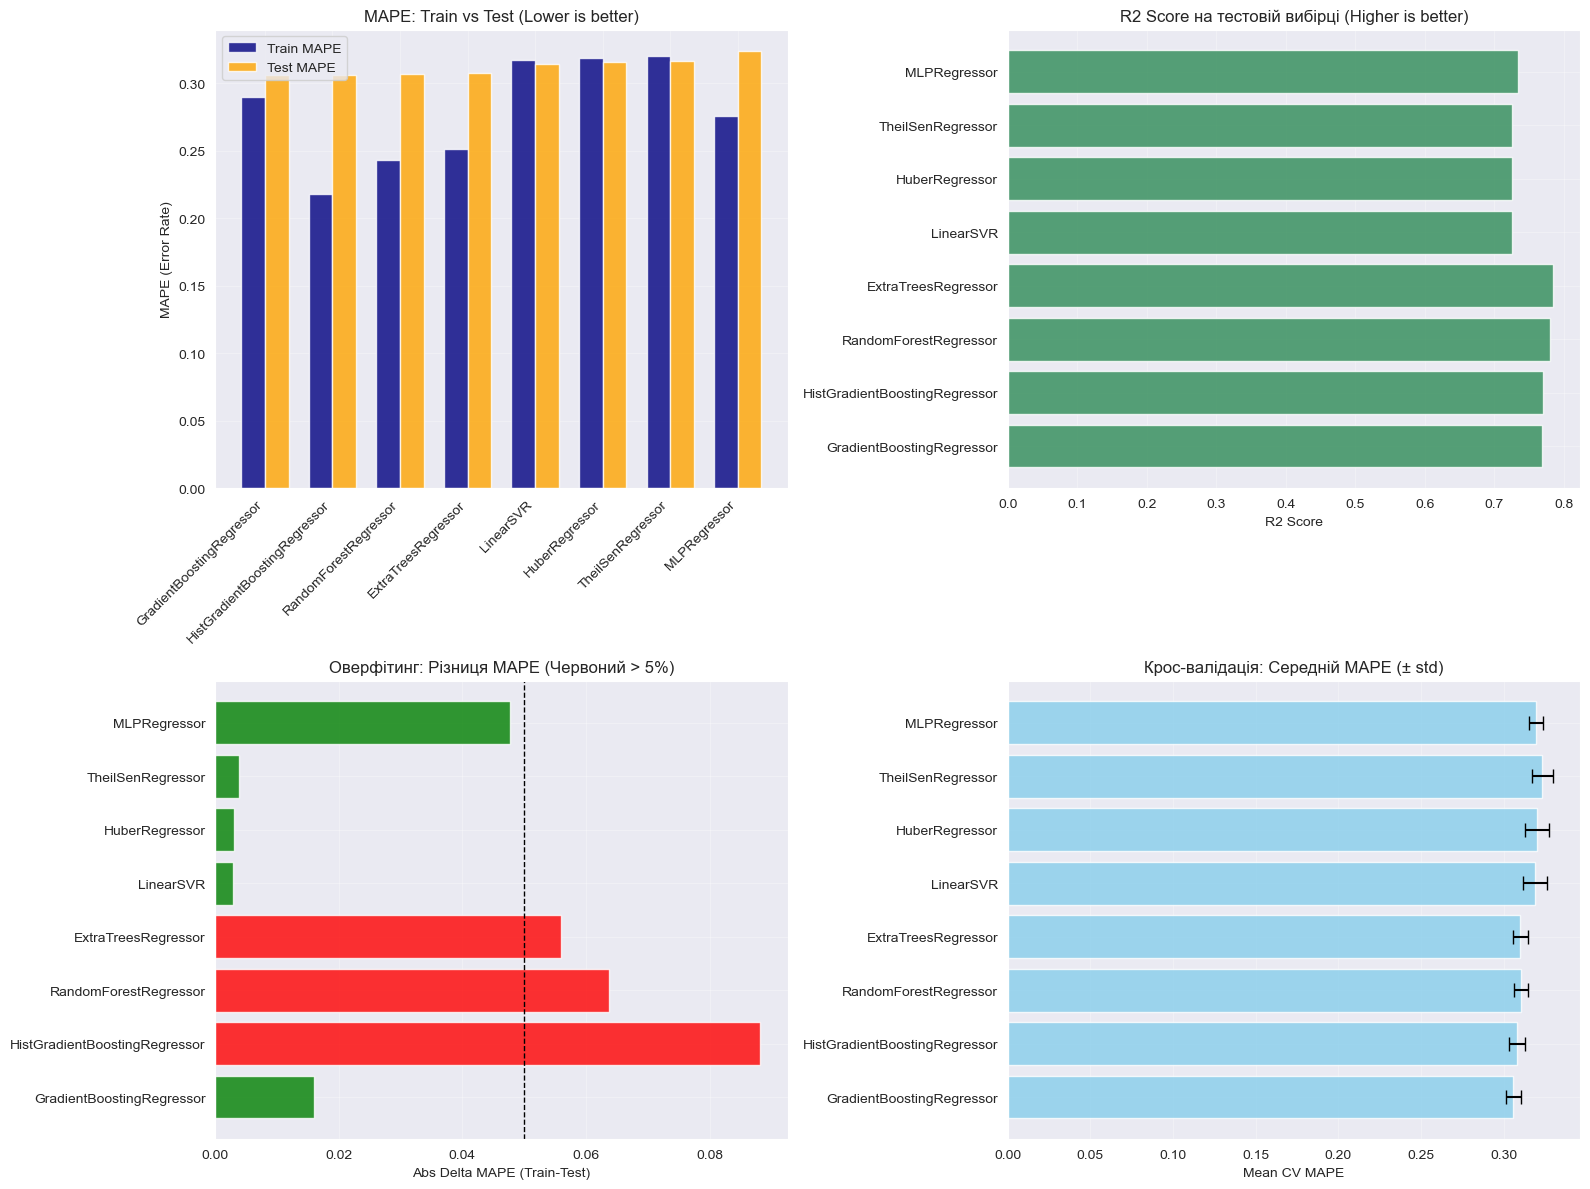


Побудова графіків для Optuna...


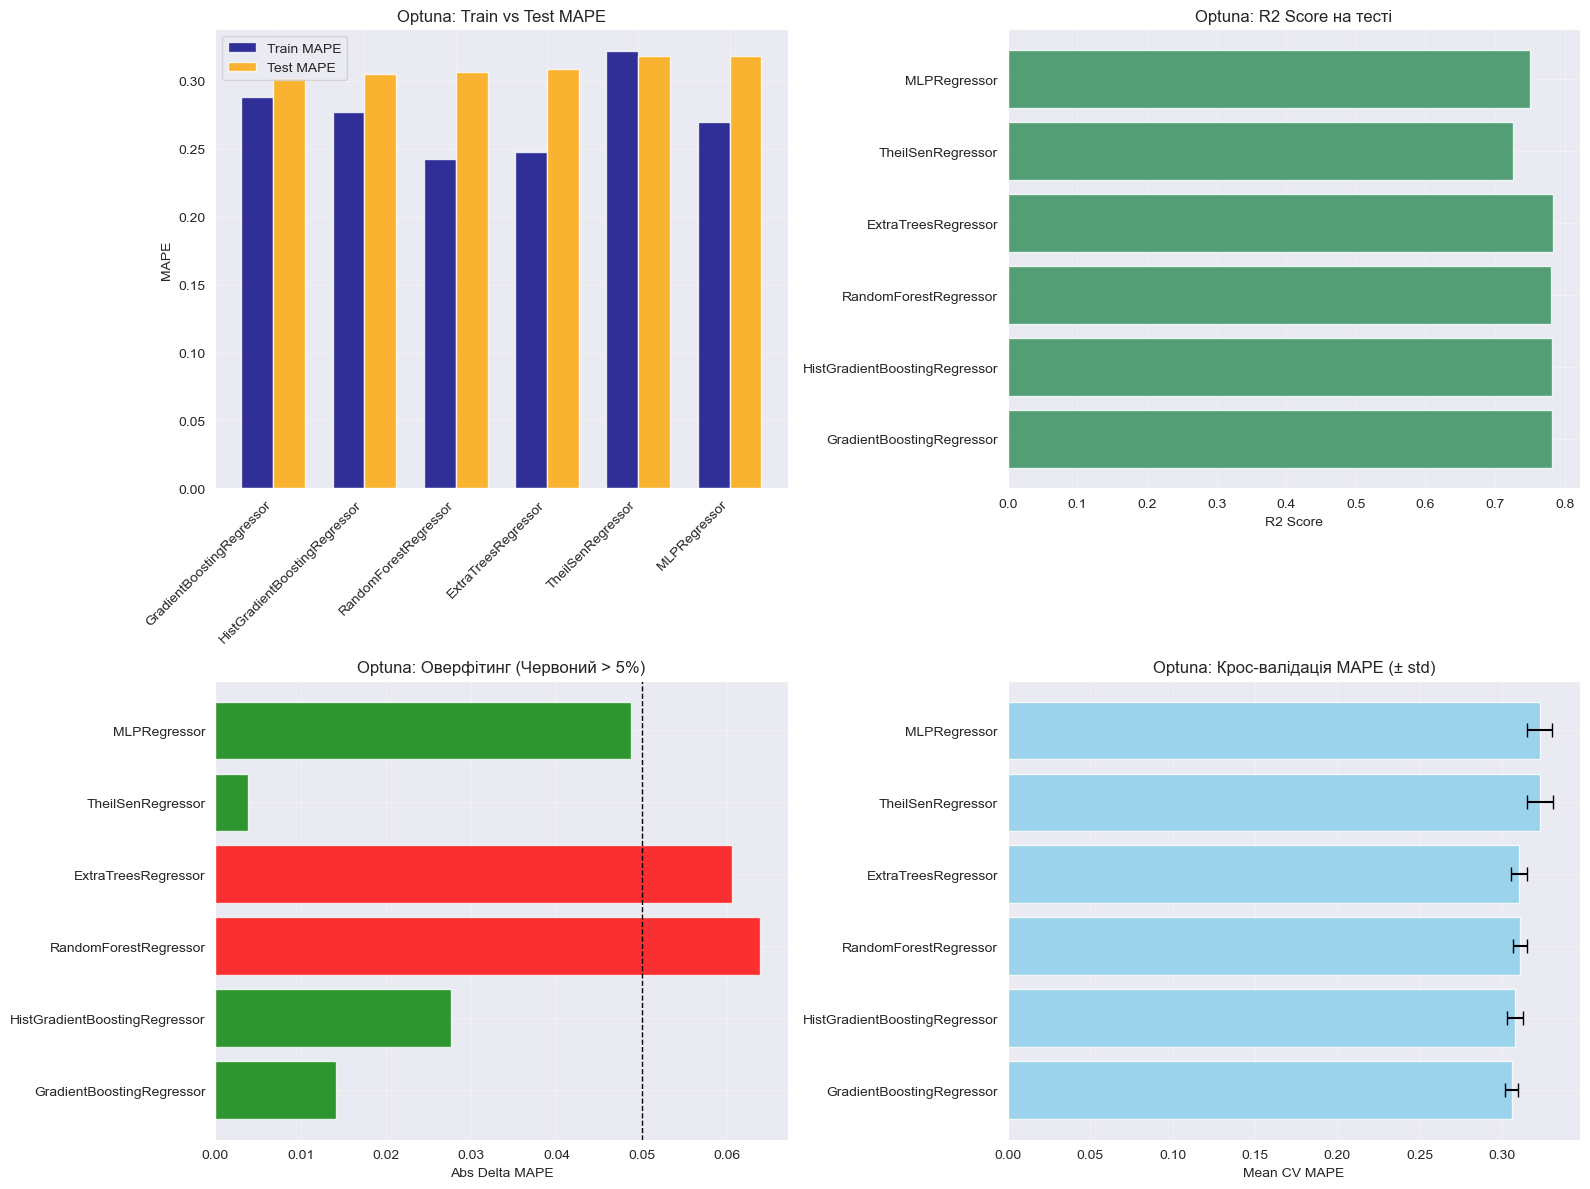

In [48]:
# Створення результатів для VotingRegressor
results_comparison_voting = pd.DataFrame([{
    'Model': 'VotingRegressor',
    'CV mape': tuned_results_voting_reg['VotingRegressor']['cv_mean_mape'],
    'CV Std': tuned_results_voting_reg['VotingRegressor']['cv_std_mape'],
    'Train MAPE': tuned_results_voting_reg['VotingRegressor']['train_mape'],
    'Test MAPE': tuned_results_voting_reg['VotingRegressor']['test_mape'],
    'Test R2': tuned_results_voting_reg['VotingRegressor']['test_r2'],
    'Train R2': tuned_results_voting_reg['VotingRegressor']['train_r2'],
    'Overfit (Train-Test)': tuned_results_voting_reg['VotingRegressor']['train_mape'] - tuned_results_voting_reg['VotingRegressor']['test_mape']
}], index=['VotingRegressor'])

# Створення результатів для StackingRegressor
results_comparison_stacking = pd.DataFrame([{
    'Model': 'StackingRegressor',
    'CV mape': tuned_results_stacking_reg['StackingRegressor']['cv_mean_mape'],
    'CV Std': tuned_results_stacking_reg['StackingRegressor']['cv_std_mape'],
    'Train MAPE': tuned_results_stacking_reg['StackingRegressor']['train_mape'],
    'Test MAPE': tuned_results_stacking_reg['StackingRegressor']['test_mape'],
    'Test R2': tuned_results_stacking_reg['StackingRegressor']['test_r2'],
    'Train R2': tuned_results_stacking_reg['StackingRegressor']['train_r2'],
    'Overfit (Train-Test)': tuned_results_stacking_reg['StackingRegressor']['train_mape'] - tuned_results_stacking_reg['StackingRegressor']['test_mape']
}], index=['StackingRegressor'])

# Порівняння результатів для всіх моделей
results_comparison = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'CV mape': [tuned_results[m]['cv_mean_mape'] for m in tuned_results],
    'CV Std': [tuned_results[m]['cv_std_mape'] for m in tuned_results],
    'Train MAPE': [tuned_results[m]['train_mape'] for m in tuned_results],
    'Test MAPE': [tuned_results[m]['test_mape'] for m in tuned_results],
    'Test R2': [tuned_results[m]['test_r2'] for m in tuned_results],
    'Train R2': [tuned_results[m]['train_r2'] for m in tuned_results],
    'Overfit (Train-Test)': [tuned_results[m]['train_mape'] - tuned_results[m]['test_mape'] 
                              for m in tuned_results]
})

# Порівняння результатів для Optuna
results_comparison_optuna = pd.DataFrame({
    'Model': list(tuned_results_optuna.keys()),
    'CV mape': [tuned_results_optuna[m]['cv_mean_mape'] for m in tuned_results_optuna],
    'CV Std': [tuned_results_optuna[m]['cv_std_mape'] for m in tuned_results_optuna],
    'Train MAPE': [tuned_results_optuna[m]['train_mape'] for m in tuned_results_optuna],
    'Test MAPE': [tuned_results_optuna[m]['test_mape'] for m in tuned_results_optuna],
    'Test R2': [tuned_results_optuna[m]['test_r2'] for m in tuned_results_optuna],
    'Train R2': [tuned_results_optuna[m]['train_r2'] for m in tuned_results_optuna],
    'Overfit (Train-Test)': [tuned_results_optuna[m]['train_mape'] - tuned_results_optuna[m]['test_mape'] 
                              for m in tuned_results_optuna]
})

# Сортуємо результати по Test MAPE
results_comparison = results_comparison.sort_values('Test MAPE', ascending=True)
results_comparison_optuna = results_comparison_optuna.sort_values('Test MAPE', ascending=True)

# Виведення результатів
print("\n" + "="*80)
print("ПІДСУМКОВЕ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("="*80)
print("GRIDSEARCH")
print(results_comparison.to_string(index=False))
print("\nOPTUNA")
print(results_comparison_optuna.to_string(index=False))
print("\nVOTING REGRESSOR")
print(results_comparison_voting.to_string(index=False))
print("\nSTACKING REGRESSOR")
print(results_comparison_stacking.to_string(index=False))

# Побудова графіків для GridSearch
import matplotlib.pyplot as plt
import numpy as np

print("\nПобудова графіків для GridSearch...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = results_comparison['Model']
x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, results_comparison['Train MAPE'], width, label='Train MAPE', alpha=0.8, color='navy')
axes[0, 0].bar(x + width/2, results_comparison['Test MAPE'], width, label='Test MAPE', alpha=0.8, color='orange')
axes[0, 0].set_ylabel('MAPE (Error Rate)')
axes[0, 0].set_title('MAPE: Train vs Test (Lower is better)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].barh(models, results_comparison['Test R2'], alpha=0.8, color='seagreen')
axes[0, 1].set_xlabel('R2 Score')
axes[0, 1].set_title('R2 Score на тестовій вибірці (Higher is better)')
axes[0, 1].grid(True, alpha=0.3)

diff_mape = results_comparison['Overfit (Train-Test)'].abs()
colors = ['red' if x > 0.05 else 'green' for x in diff_mape]
axes[1, 0].barh(models, diff_mape, alpha=0.8, color=colors)
axes[1, 0].set_xlabel('Abs Delta MAPE (Train-Test)')
axes[1, 0].set_title('Оверфітинг: Різниця MAPE (Червоний > 5%)')
axes[1, 0].axvline(x=0.05, color='black', linestyle='--', linewidth=1)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].barh(models, results_comparison['CV mape'], 
                xerr=results_comparison['CV Std'], 
                alpha=0.8, color='skyblue', capsize=5)
axes[1, 1].set_xlabel('Mean CV MAPE')
axes[1, 1].set_title('Крос-валідація: Середній MAPE (± std)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_results_gridsearch.png', dpi=300)
plt.show()

# Побудова графіків для Optuna...
print("\nПобудова графіків для Optuna...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_opt = results_comparison_optuna['Model']
x_opt = np.arange(len(models_opt))

axes[0, 0].bar(x_opt - width/2, results_comparison_optuna['Train MAPE'], width, label='Train MAPE', alpha=0.8, color='navy')
axes[0, 0].bar(x_opt + width/2, results_comparison_optuna['Test MAPE'], width, label='Test MAPE', alpha=0.8, color='orange')
axes[0, 0].set_ylabel('MAPE')
axes[0, 0].set_title('Optuna: Train vs Test MAPE')
axes[0, 0].set_xticks(x_opt)
axes[0, 0].set_xticklabels(models_opt, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].barh(models_opt, results_comparison_optuna['Test R2'], alpha=0.8, color='seagreen')
axes[0, 1].set_xlabel('R2 Score')
axes[0, 1].set_title('Optuna: R2 Score на тесті')
axes[0, 1].grid(True, alpha=0.3)

diff_mape_opt = results_comparison_optuna['Overfit (Train-Test)'].abs()
colors_opt = ['red' if x > 0.05 else 'green' for x in diff_mape_opt]
axes[1, 0].barh(models_opt, diff_mape_opt, alpha=0.8, color=colors_opt)
axes[1, 0].set_xlabel('Abs Delta MAPE')
axes[1, 0].set_title('Optuna: Оверфітинг (Червоний > 5%)')
axes[1, 0].axvline(x=0.05, color='black', linestyle='--', linewidth=1)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].barh(models_opt, results_comparison_optuna['CV mape'], 
                xerr=results_comparison_optuna['CV Std'], 
                alpha=0.8, color='skyblue', capsize=5)
axes[1, 1].set_xlabel('Mean CV MAPE')
axes[1, 1].set_title('Optuna: Крос-валідація MAPE (± std)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_results_optuna.png', dpi=300)
plt.show()


In [49]:
final_combined_results = pd.concat([
        results_comparison_optuna,
        results_comparison_voting,
        results_comparison_stacking
    ], ignore_index=True)
final_combined_results = final_combined_results.sort_values('Test MAPE', ascending=False).round(4).reset_index(drop=True)

print("\n" + "="*80)
print("ОБ'ЄДНАНІ РЕЗУЛЬТАТИ: Індивідуальні Optuna та Ансамблеві моделі")
print("="*80)
print(final_combined_results.to_string(index=False))


ОБ'ЄДНАНІ РЕЗУЛЬТАТИ: Індивідуальні Optuna та Ансамблеві моделі
                        Model  CV mape  CV Std  Train MAPE  Test MAPE  Test R2  Train R2  Overfit (Train-Test)
                 MLPRegressor   0.3227  0.0077      0.2694     0.3182   0.7495    0.8122               -0.0487
            TheilSenRegressor   0.3229  0.0078      0.3218     0.3179   0.7257    0.7146                0.0038
          ExtraTreesRegressor   0.3103  0.0050      0.2478     0.3083   0.7829    0.8478               -0.0606
        RandomForestRegressor   0.3108  0.0040      0.2426     0.3065   0.7809    0.8564               -0.0639
HistGradientBoostingRegressor   0.3078  0.0046      0.2773     0.3049   0.7820    0.8118               -0.0276
            StackingRegressor   0.3079  0.0043      0.2375     0.3034   0.7825    0.8610               -0.0659
              VotingRegressor   0.3078  0.0045      0.2660     0.3033   0.7813    0.8227               -0.0372
    GradientBoostingRegressor   0.3057  0.0041 

Побудова графіків регресії для моделей...
  GradientBoostingRegressor: MAPE = 0.3061
  HistGradientBoostingRegressor: MAPE = 0.3064
  RandomForestRegressor: MAPE = 0.3070
  ExtraTreesRegressor: MAPE = 0.3073
  LinearSVR: MAPE = 0.3145
  HuberRegressor: MAPE = 0.3159
  MLPRegressor: MAPE = 0.3237
  TheilSenRegressor: MAPE = 0.3167


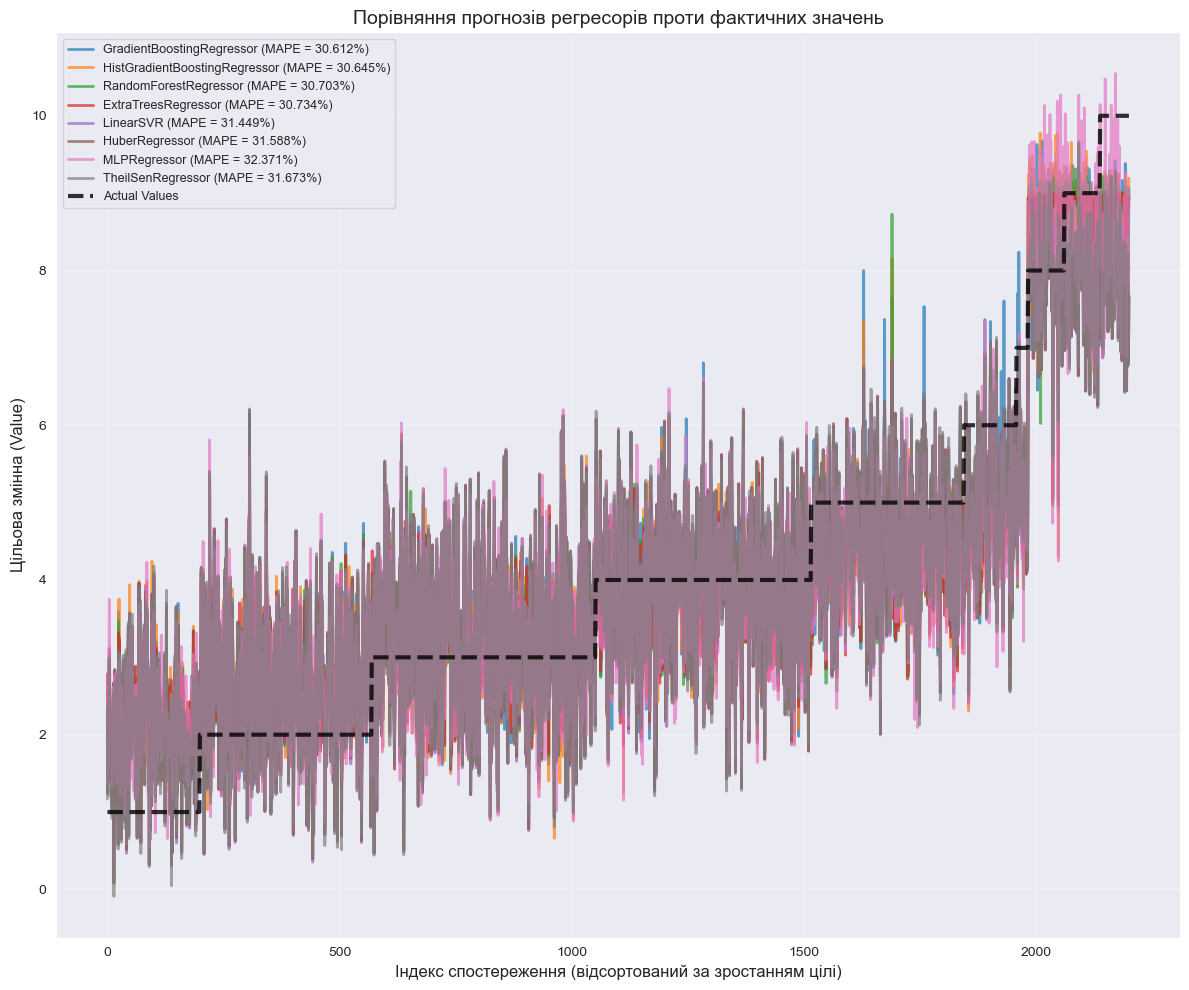

Графіки регресії побудовано!


In [50]:
plt.figure(figsize=(12, 10))

sort_idx = np.argsort(y_test)
y_test_sorted = y_test.iloc[sort_idx] if hasattr(y_test, 'iloc') else y_test[sort_idx]

print("Побудова графіків регресії для моделей...")
print("="*80)

for name in tuned_results.keys():
    try:
        model = tuned_results[name]['model']
        y_pred = model.predict(X_test)
        y_pred_sorted = y_pred[sort_idx]

        from sklearn.metrics import mean_absolute_percentage_error
        mape = mean_absolute_percentage_error(y_test, y_pred)

        plt.plot(range(len(y_test_sorted)), y_pred_sorted, 
                 label=f"{name} (MAPE = {mape:.3%})", 
                 linewidth=2, alpha=0.7)
        
        print(f"  {name}: MAPE = {mape:.4f}")
        
    except Exception as e:
        print(f"  {name}: Помилка - {e}")
        continue

plt.plot(range(len(y_test_sorted)), y_test_sorted, 
         color='black', linestyle='--', linewidth=3, label='Actual Values', alpha=0.8)

plt.xlabel('Індекс спостереження (відсортований за зростанням цілі)', fontsize=12)
plt.ylabel('Цільова змінна (Value)', fontsize=12)
plt.title('Порівняння прогнозів регресорів проти фактичних значень', fontsize=14)
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regression_prediction_comparison.png', dpi=300)
plt.show()

print("="*80)
print("Графіки регресії побудовано!")

ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ РЕГРЕСІЙНОЇ МОДЕЛІ: GradientBoostingRegressor

Звіт по метриках: Тренувальна вибірка
----------------------------------------
R2 Score: 0.7928
MAE:      0.7713
RMSE:     0.9627
MAPE:     28.79%

Звіт по метриках: Тестова вибірка
----------------------------------------
R2 Score: 0.7813
MAE:      0.8105
RMSE:     1.0067
MAPE:     30.21%


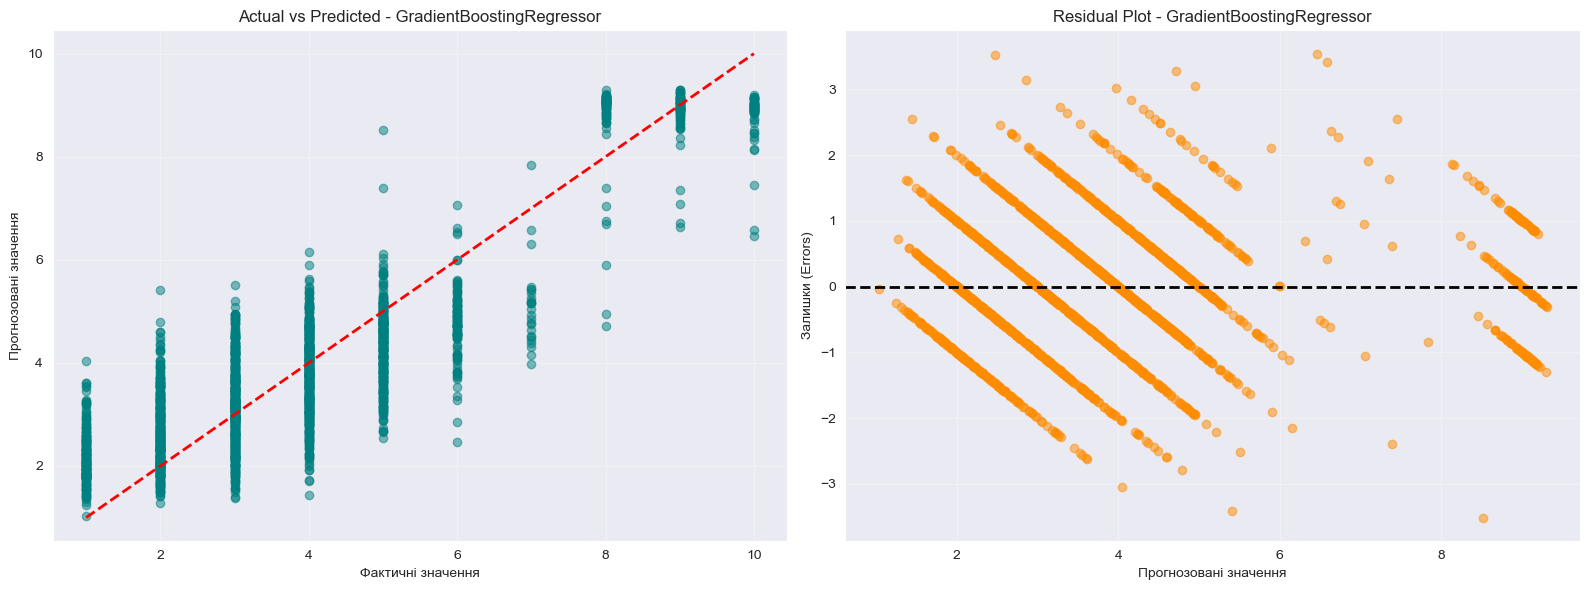


ВАЖЛИВІСТЬ ОЗНАК ДЛЯ GradientBoostingRegressor
                          Feature  Importance
              Stress Level (1-10)    0.666100
                      Sleep Hours    0.192510
     Therapy Sessions (per month)    0.084457
         Caffeine Intake (mg/day)    0.030174
     Physical Activity (hrs/week)    0.006580
              Diet Quality (1-10)    0.004150
             Sweating Level (1-5)    0.002669
                 Heart Rate (bpm)    0.002579
                              Age    0.002508
Alcohol Consumption (drinks/week)    0.002200
        Family History of Anxiety    0.001841
     Breathing Rate (breaths/min)    0.001753
                       Occupation    0.001130
                       Medication    0.000405
                           Gender    0.000343


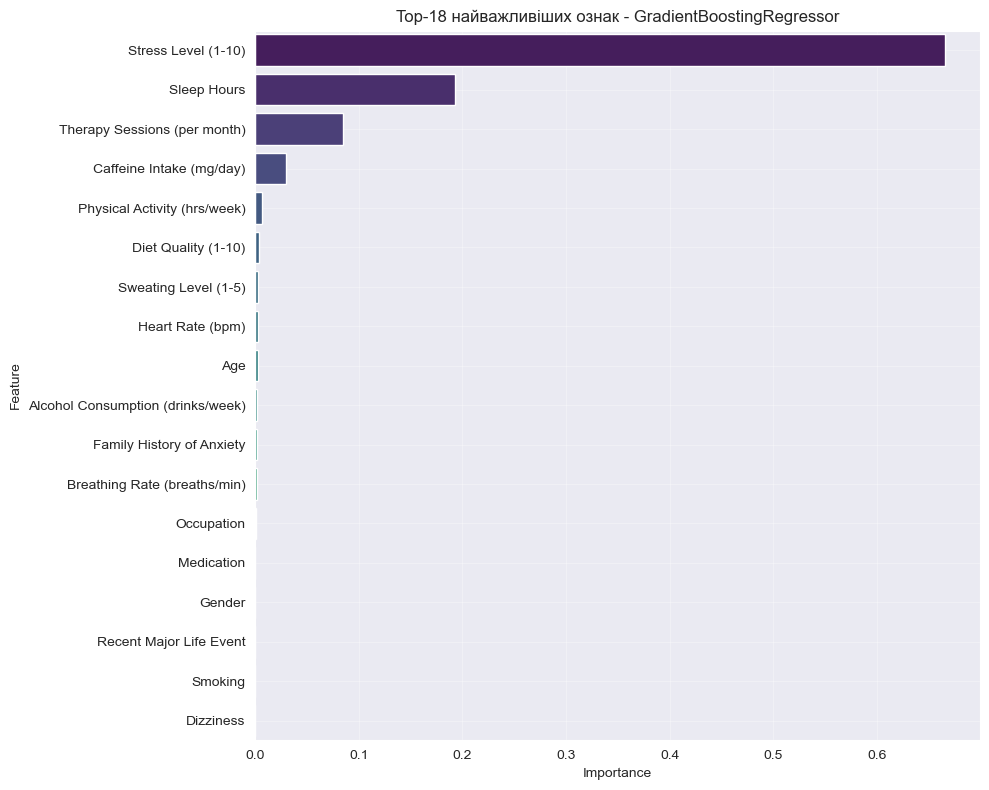

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

best_model_name = results_comparison_optuna.iloc[0]['Model']
best_model_obj = tuned_results_optuna[best_model_name]['model']

print("="*80)
print(f"ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ РЕГРЕСІЙНОЇ МОДЕЛІ: {best_model_name}")
print("="*80)

y_train_pred = best_model_obj.predict(X_train)
y_test_pred = best_model_obj.predict(X_test)

def print_regression_report(y_true, y_pred, title):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\nЗвіт по метриках: {title}")
    print("-" * 40)
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE:      {mae:.4f}")
    print(f"RMSE:     {rmse:.4f}")
    print(f"MAPE:     {mape:.2%}")

print_regression_report(y_train, y_train_pred, "Тренувальна вибірка")
print_regression_report(y_test, y_test_pred, "Тестова вибірка")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_test, y_test_pred, alpha=0.5, color='teal')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Фактичні значення')
ax1.set_ylabel('Прогнозовані значення')
ax1.set_title(f'Actual vs Predicted - {best_model_name}')
ax1.grid(True, alpha=0.3)

residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.5, color='darkorange')
ax2.axhline(y=0, color='black', linestyle='--', lw=2)
ax2.set_xlabel('Прогнозовані значення')
ax2.set_ylabel('Залишки (Errors)')
ax2.set_title(f'Residual Plot - {best_model_name}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_diagnostic_plots.png', dpi=300)
plt.show()

print("\n" + "="*80)
print(f"ВАЖЛИВІСТЬ ОЗНАК ДЛЯ {best_model_name}")
print("="*80)

importances = None
if hasattr(best_model_obj, 'feature_importances_'):
    importances = best_model_obj.feature_importances_
elif hasattr(best_model_obj, 'coef_'):
    importances = np.abs(best_model_obj.coef_)

if importances is not None:
    feature_imp_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(feature_imp_df.head(15).to_string(index=False))
    
    top_n = min(20, len(feature_imp_df))
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(top_n), palette='viridis')
    plt.title(f'Top-{top_n} найважливіших ознак - {best_model_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance_regression.png', dpi=300)
    plt.show()
else:
    print(f"Модель {best_model_name} не підтримує прямий вивід важливості ознак.")


АНАЛІЗ ВЕЛИКИХ ПОМИЛОК РЕГРЕСІЇ (TEST)
Загальний MAPE для Test: 30.21%
Поріг аналізу (топ-10% помилок): 30.34%

ТОП-10 ОБ'ЄКТІВ З НАЙБІЛЬШОЮ ВІДНОСНОЮ ПОМИЛКОЮ:
--------------------------------------------------------------------------------


,True_Value,Predicted_Value,Abs_Error,APE_%,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),...,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10)
4889,1.0,4.043536,3.043536,304.353572,28.0,Other,Lawyer,7.8,7.4,569.0,...,No,7.0,64.0,17.0,1.0,No,No,2.0,Yes,4.0
10117,1.0,3.616827,2.616827,261.682743,26.0,Other,Athlete,6.0,0.2,296.0,...,Yes,5.0,89.0,20.0,1.0,No,Yes,3.0,Yes,3.0
8330,1.0,3.604730,2.604730,260.472951,30.0,Male,Freelancer,8.7,4.6,273.0,...,Yes,7.0,115.0,22.0,2.0,No,No,4.0,No,1.0
8701,1.0,3.554584,2.554584,255.458436,37.0,Female,Athlete,5.9,4.7,130.0,...,Yes,5.0,98.0,21.0,4.0,Yes,No,3.0,No,7.0
10310,1.0,3.526769,2.526769,252.676881,46.0,Male,Other,6.5,1.3,57.0,...,No,7.0,114.0,23.0,4.0,Yes,No,0.0,Yes,9.0
1905,1.0,3.456744,2.456744,245.674389,56.0,Other,Student,6.2,3.9,353.0,...,Yes,5.0,82.0,22.0,4.0,No,No,2.0,No,1.0
9570,1.0,3.285839,2.285839,228.583937,27.0,Other,Scientist,7.5,3.0,259.0,...,No,6.0,78.0,26.0,4.0,Yes,Yes,0.0,Yes,7.0
1383,1.0,3.265889,2.265889,226.588904,29.0,Other,Freelancer,5.9,5.4,324.0,...,No,5.0,69.0,28.0,5.0,Yes,No,1.0,Yes,9.0
608,1.0,3.247249,2.247249,224.724869,32.0,Other,Artist,5.1,4.1,298.0,...,No,5.0,100.0,27.0,2.0,No,Yes,0.0,Yes,9.0
1511,1.0,3.220807,2.220807,222.080657,45.0,Male,Lawyer,7.5,3.3,374.0,...,Yes,4.0,72.0,14.0,3.0,No,No,7.0,No,4.0


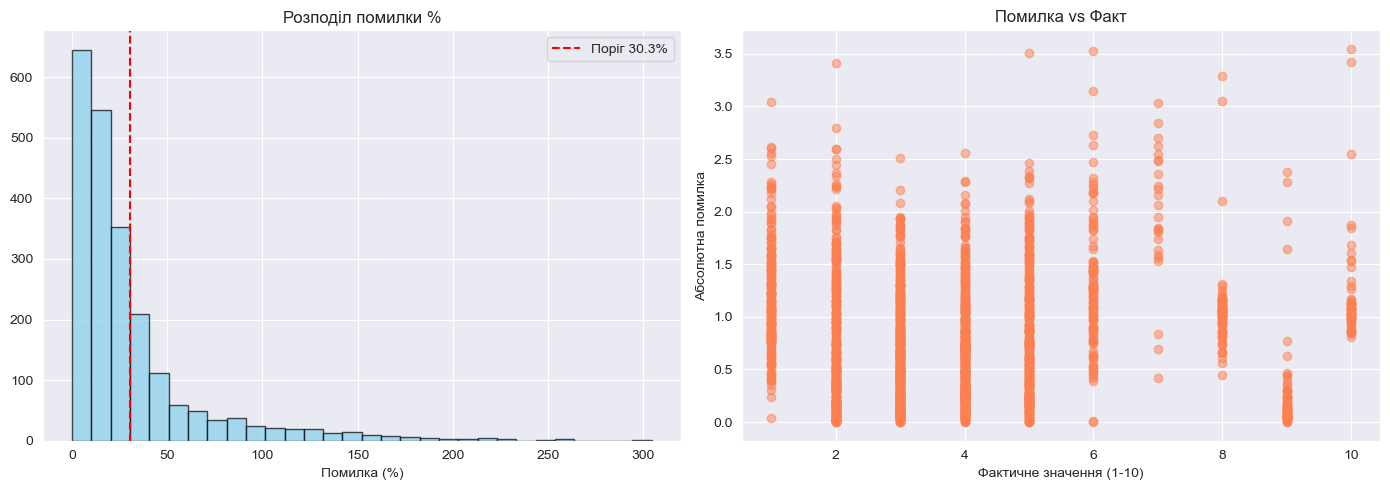

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def perform_regression_error_analysis(X, y_true, y_pred, dataset_name="Test", filename="plot.png", scaler=None, label_encoders=None):
    print("\n" + "="*80)
    print(f"АНАЛІЗ ВЕЛИКИХ ПОМИЛОК РЕГРЕСІЇ ({dataset_name.upper()})")
    print("="*80)

    # 1. Повертаємо X до початкового стану (до стандартизації)
    # Це важливо, бо інакше LabelEncoder отримає від'ємні числа замість 0, 1, 2...
    if scaler is not None:
        X_orig = pd.DataFrame(
            scaler.inverse_transform(X), 
            columns=X.columns, 
            index=X.index
        )
    else:
        X_orig = X.copy()

    # 2. Перетворюємо числа назад у назви категорій
    if label_encoders is not None:
        for col, encoder in label_encoders.items():
            if col in X_orig.columns:
                # Використовуємо .round(), щоб уникнути помилок точності float (напр. 0.99 -> 1)
                X_orig[col] = encoder.inverse_transform(X_orig[col].round().astype(int))

    # 3. Цільова змінна (Anxiety Level) у вас НЕ стандартизувалась (клітинка №7),
    # тому y_true та y_pred вже в оригінальних одиницях (1-10)
    y_true_orig = np.array(y_true).flatten()
    y_pred_orig = np.array(y_pred).flatten()

    # 4. Розрахунок помилок
    abs_errors = np.abs(y_true_orig - y_pred_orig)
    ape = abs_errors / np.where(y_true_orig == 0, 1e-10, np.abs(y_true_orig))
    
    # 5. Створення таблиці результатів (index=X.index прибирає NaN)
    errors_df = pd.DataFrame({
        'True_Value': y_true_orig,
        'Predicted_Value': y_pred_orig,
        'Abs_Error': abs_errors,
        'APE_%': ape * 100
    }, index=X.index)
    
    full_errors_df = pd.concat([errors_df, X_orig], axis=1)
    
    # Визначаємо топ-10% помилок
    threshold = errors_df['APE_%'].quantile(0.70) 
    outliers_df = full_errors_df[full_errors_df['APE_%'] >= threshold].sort_values('APE_%', ascending=False)

    print(f"Загальний MAPE для {dataset_name}: {ape.mean():.2%}")
    print(f"Поріг аналізу (топ-10% помилок): {threshold:.2f}%")
    print(f"\nТОП-10 ОБ'ЄКТІВ З НАЙБІЛЬШОЮ ВІДНОСНОЮ ПОМИЛКОЮ:")
    print("-" * 80)
    
    from IPython.display import display
    display(outliers_df.head(10))
    
    # 6. Візуалізація
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(errors_df['APE_%'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(threshold, color='red', linestyle='--', label=f'Поріг {threshold:.1f}%')
    axes[0].set_title(f'Розподіл помилки %')
    axes[0].set_xlabel('Помилка (%)')
    axes[0].legend()

    axes[1].scatter(y_true_orig, abs_errors, alpha=0.5, color='coral')
    axes[1].set_title(f'Помилка vs Факт')
    axes[1].set_xlabel('Фактичне значення (1-10)')
    axes[1].set_ylabel('Абсолютна помилка')
    
    plt.tight_layout()
    os.makedirs(os.path.dirname(filename), exist_ok=True) if os.path.dirname(filename) else None
    plt.savefig(filename, dpi=300)
    plt.show()



# 2. Запустіть аналіз
perform_regression_error_analysis(
    X_test, y_test, y_test_pred, 
    dataset_name="Test", 
    filename="results/regression/graphics/errors_test.png", 
    scaler=scaler, 
    label_encoders=label_encoders
)


ПОВНИЙ АНАЛІЗ ТА ЗБЕРЕЖЕННЯ ДІАГРАМ (TEST)
Загальний MAPE: 30.21%
Поріг великої помилки (90-й перцентиль): 30.34%


,True_Value,Predicted_Value,Residual,APE_%,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),...,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10)
3984,1.0,1.786394,0.786394,78.639375,23.0,Female,Student,6.7,1.1,290.0,...,No,1.0,74.0,18.0,2.0,No,Yes,0.0,No,9.0
3111,1.0,2.521282,1.521282,152.128212,26.0,Male,Teacher,6.4,3.8,36.0,...,Yes,3.0,115.0,26.0,4.0,No,Yes,4.0,No,8.0
4040,3.0,1.500519,-1.499481,49.982712,44.0,Male,Freelancer,7.5,2.6,128.0,...,No,2.0,64.0,24.0,1.0,No,No,0.0,Yes,1.0
6607,5.0,3.340957,-1.659043,33.180854,57.0,Female,Scientist,5.8,2.9,312.0,...,No,5.0,70.0,25.0,4.0,No,Yes,1.0,No,6.0
9886,2.0,3.264006,1.264006,63.200313,47.0,Other,Engineer,4.9,2.1,457.0,...,No,4.0,80.0,22.0,1.0,Yes,Yes,1.0,Yes,10.0


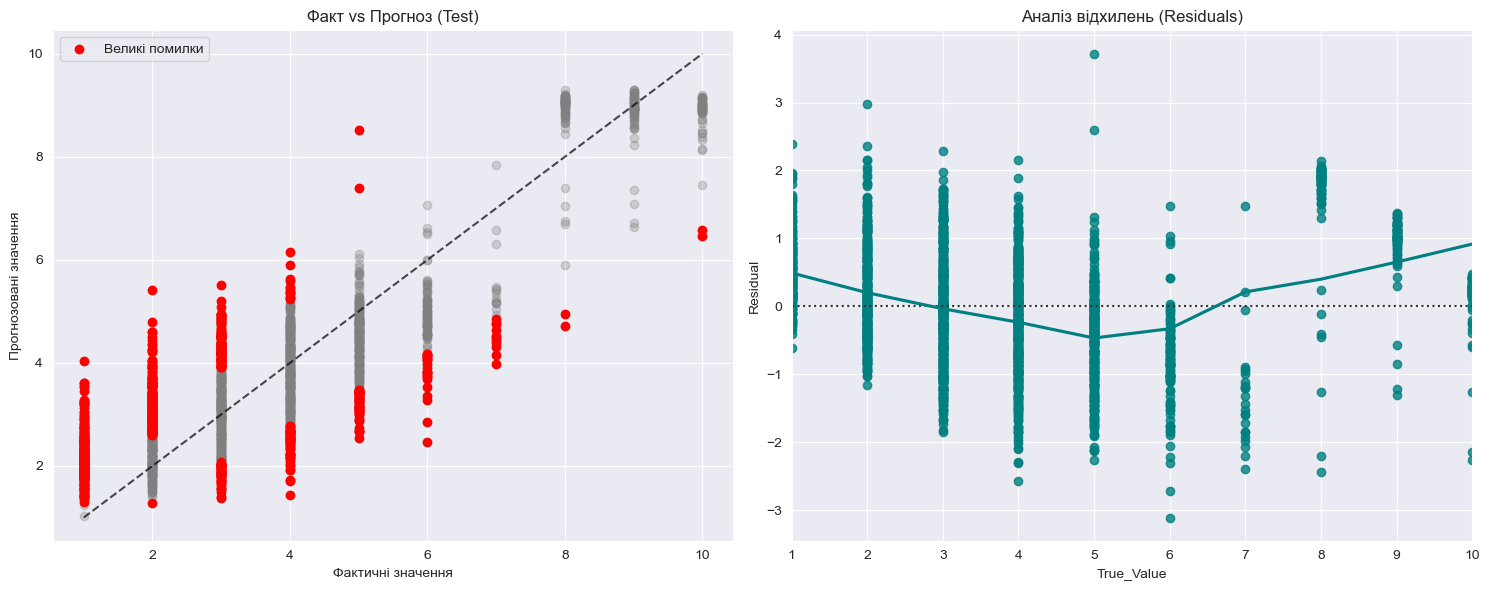

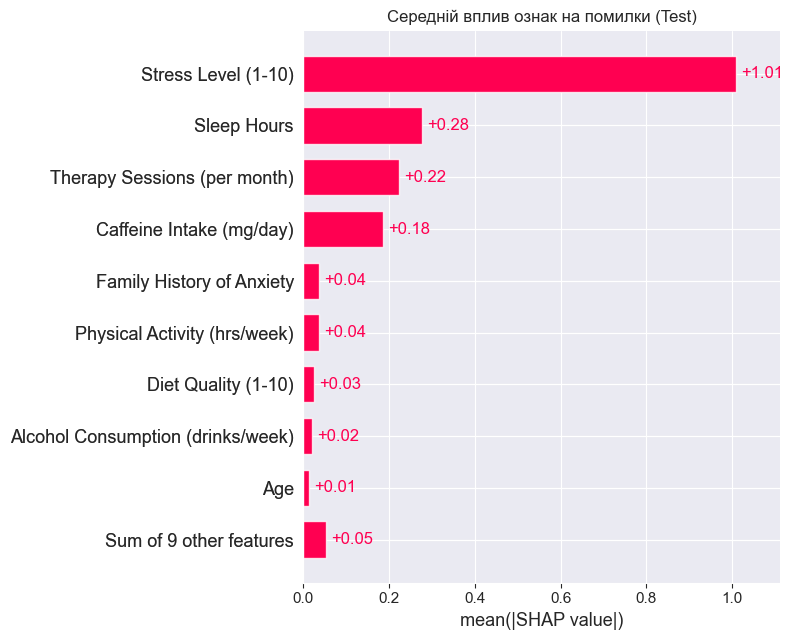

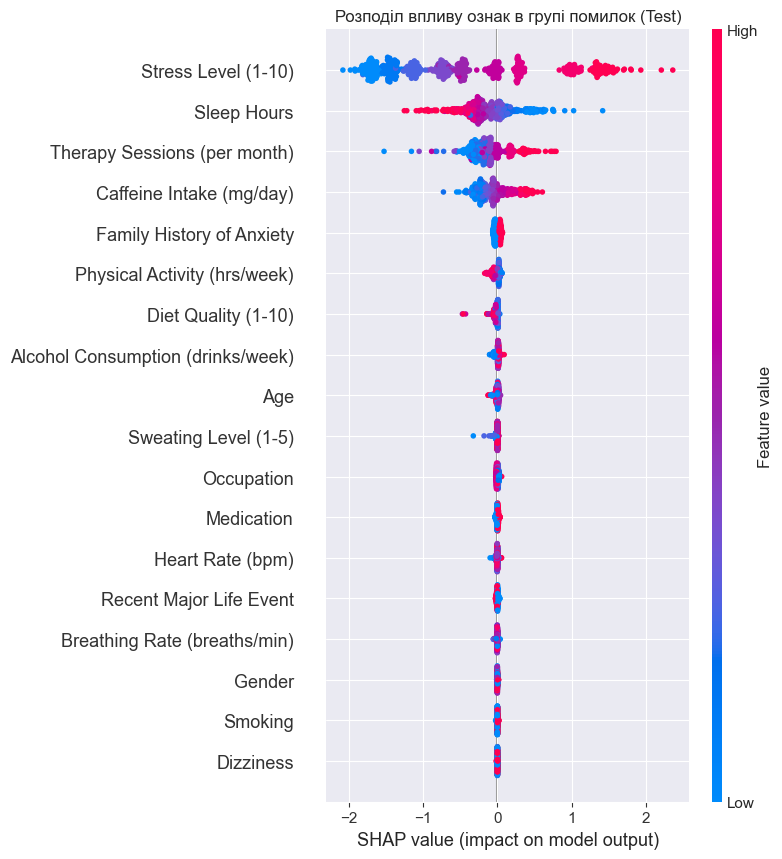


Усі діаграми збережено у папку: results/regression/


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

def perform_full_error_analysis(model, X_test, y_test, y_pred, scaler, label_encoders, dataset_name="Test", save_path="results/analysis/"):
    """
    Повний аналіз: Дестандартизація + Статистика помилок + SHAP + Збереження графіків
    """
    # Створюємо папку для збереження, якщо її немає
    os.makedirs(save_path, exist_ok=True)
    
    print("\n" + "="*80)
    print(f"ПОВНИЙ АНАЛІЗ ТА ЗБЕРЕЖЕННЯ ДІАГРАМ ({dataset_name.upper()})")
    print("="*80)

    # 1. ДЕСТАНДАРТИЗАЦІЯ
    X_orig = pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns, index=X_test.index)
    for col, encoder in label_encoders.items():
        if col in X_orig.columns:
            X_orig[col] = encoder.inverse_transform(X_orig[col].round().astype(int))

    y_true_orig = np.array(y_test).flatten()
    y_pred_orig = np.array(y_pred).flatten()

    # 2. РОЗРАХУНОК ПОМИЛОК
    residuals = y_pred_orig - y_true_orig
    abs_errors = np.abs(residuals)
    ape = (abs_errors / np.where(y_true_orig == 0, 1e-10, np.abs(y_true_orig))) * 100
    
    results_df = pd.DataFrame({
        'True_Value': y_true_orig,
        'Predicted_Value': y_pred_orig,
        'Residual': residuals,
        'APE_%': ape
    }, index=X_test.index)
    
    full_df = pd.concat([results_df, X_orig], axis=1)
    
    # 3. ВИДІЛЕННЯ ГРУПИ ПОМИЛОК (Топ-10%)
    threshold = full_df['APE_%'].quantile(0.70)
    outliers = full_df[full_df['APE_%'] >= threshold].copy()
    
    print(f"Загальний MAPE: {full_df['APE_%'].mean():.2f}%")
    print(f"Поріг великої помилки (90-й перцентиль): {threshold:.2f}%")
    display(outliers.head(5))

    # 4. ПЕРША ДІАГРАМА: Факт vs Прогноз та Залишки
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    axes[0].scatter(full_df['True_Value'], full_df['Predicted_Value'], alpha=0.3, color='gray')
    axes[0].scatter(outliers['True_Value'], outliers['Predicted_Value'], color='red', label='Великі помилки')
    axes[0].plot([y_true_orig.min(), y_true_orig.max()], [y_true_orig.min(), y_true_orig.max()], 'k--', alpha=0.7)
    axes[0].set_title(f"Факт vs Прогноз ({dataset_name})")
    axes[0].set_xlabel("Фактичні значення")
    axes[0].set_ylabel("Прогнозовані значення")
    axes[0].legend()

    # Residual plot
    sns.residplot(data=full_df, x='True_Value', y='Residual', lowess=True, ax=axes[1], color="teal")
    axes[1].set_title("Аналіз відхилень (Residuals)")
    
    plt.tight_layout()
    # Зберігаємо
    plt.savefig(os.path.join(save_path, f"regression_residuals_{dataset_name}.png"), dpi=300)
    plt.show()
    
    # 5. SHAP АНАЛІЗ
    explainer = shap.TreeExplainer(model)
    shap_values_all = explainer(X_test, check_additivity=False)
    outlier_indices = [X_test.index.get_loc(idx) for idx in outliers.index]
    shap_values_outliers = shap_values_all[outlier_indices]

    # ДРУГА ДІАГРАМА: Усереднена важливість (Bar Plot)
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values_outliers, max_display=10, show=False)
    plt.title(f"Середній вплив ознак на помилки ({dataset_name})")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"shap_bar_errors_{dataset_name}.png"), dpi=300)
    plt.show()
    
    # ТРЕТЯ ДІАГРАМА: Розподіл впливу (Summary Plot)
    plt.figure(figsize=(10, 6))
    # Summary plot не підтримує show=False безпосередньо в старих версіях, 
    # тому використовуємо plt.gcf() (get current figure)
    shap.summary_plot(shap_values_outliers, X_test.iloc[outlier_indices], 
                      feature_names=X_orig.columns, show=False)
    plt.title(f"Розподіл впливу ознак в групі помилок ({dataset_name})")
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"shap_summary_errors_{dataset_name}.png"), dpi=300)
    plt.show()

    print(f"\nУсі діаграми збережено у папку: {save_path}")
    return outliers

# ВИКЛИК
outliers_analysis = perform_full_error_analysis(
    model=best_model_obj, # або ваша змінна моделі
    X_test=X_test, 
    y_test=y_test, 
    y_pred=y_test_pred, 
    scaler=scaler, 
    label_encoders=label_encoders,
    dataset_name="Test",
    save_path="results/regression/"
)

In [157]:
outliers_analysis['Predicted_Value'].round(0)
len(outliers_analysis)

660

In [158]:
outliers_analysis

,True_Value,Predicted_Value,Residual,APE_%,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),...,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10)
3984,1.0,2.0,1.0,79.0,23.0,Female,Student,7.0,1.0,290.0,...,No,1.0,74.0,18.0,2.0,No,Yes,0.0,No,9.0
3111,1.0,3.0,2.0,152.0,26.0,Male,Teacher,6.0,4.0,36.0,...,Yes,3.0,115.0,26.0,4.0,No,Yes,4.0,No,8.0
4040,3.0,2.0,-1.0,50.0,44.0,Male,Freelancer,8.0,3.0,128.0,...,No,2.0,64.0,24.0,1.0,No,No,0.0,Yes,1.0
6607,5.0,3.0,-2.0,33.0,57.0,Female,Scientist,6.0,3.0,312.0,...,No,5.0,70.0,25.0,4.0,No,Yes,1.0,No,6.0
9886,2.0,3.0,1.0,63.0,47.0,Other,Engineer,5.0,2.0,457.0,...,No,4.0,80.0,22.0,1.0,Yes,Yes,1.0,Yes,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7960,1.0,3.0,2.0,159.0,33.0,Other,Other,8.0,4.0,19.0,...,Yes,4.0,78.0,19.0,1.0,Yes,Yes,4.0,No,2.0
9416,3.0,4.0,1.0,40.0,49.0,Female,Doctor,7.0,6.0,579.0,...,No,7.0,100.0,23.0,5.0,No,No,2.0,No,9.0
8921,1.0,1.0,0.0,42.0,29.0,Female,Chef,10.0,4.0,284.0,...,Yes,3.0,116.0,29.0,2.0,Yes,No,2.0,Yes,10.0
2058,3.0,4.0,1.0,44.0,37.0,Other,Scientist,7.0,3.0,403.0,...,Yes,7.0,87.0,15.0,4.0,No,No,3.0,Yes,9.0


In [159]:
len(X_test)

2200

In [160]:
outliers_analysis.describe()

,True_Value,Predicted_Value,Residual,APE_%,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10)
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,2.590909,3.068182,0.477273,70.639394,40.184848,7.034848,3.101515,263.410606,9.313636,4.615152,88.993939,20.621212,3.116667,1.880303,5.374242
std,1.575392,1.055322,1.459966,46.039308,13.477652,1.149123,1.789447,139.606969,5.864954,2.747947,17.243942,5.140707,1.423847,1.664384,2.833402
min,1.000000,1.000000,-4.000000,30.000000,18.000000,4.000000,0.000000,3.000000,0.000000,1.000000,60.000000,12.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,-1.000000,38.000000,29.000000,6.000000,2.000000,149.500000,4.000000,2.000000,74.000000,16.000000,2.000000,1.000000,3.000000
50%,2.000000,3.000000,1.000000,52.000000,40.000000,7.000000,3.000000,253.000000,9.000000,4.000000,89.000000,21.000000,3.000000,2.000000,5.000000
75%,3.000000,4.000000,1.000000,87.000000,52.000000,8.000000,4.000000,349.250000,15.000000,7.000000,104.000000,25.000000,4.000000,3.000000,8.000000
max,10.000000,9.000000,4.000000,304.000000,64.000000,10.000000,10.000000,595.000000,19.000000,10.000000,119.000000,29.000000,5.000000,9.000000,10.000000


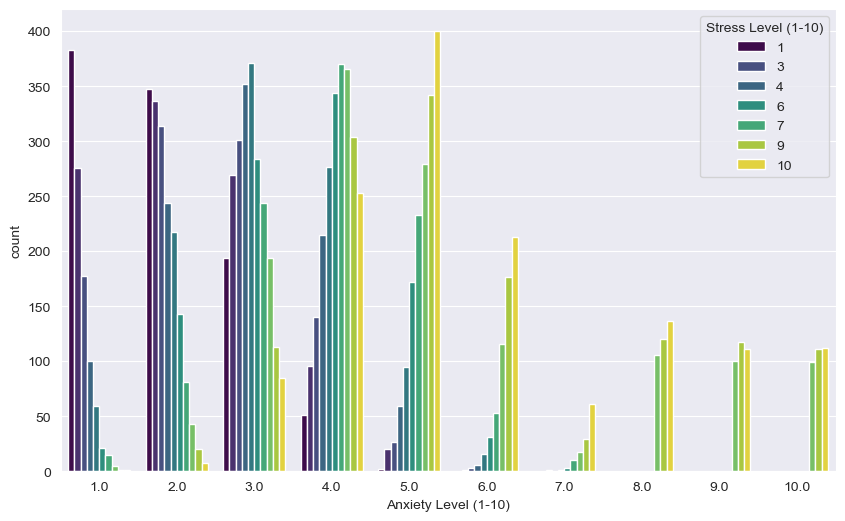

In [161]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Anxiety Level (1-10)' , hue='Stress Level (1-10)',palette='viridis')
plt.savefig('anxiety_stress_level_distribution.png', dpi=300)

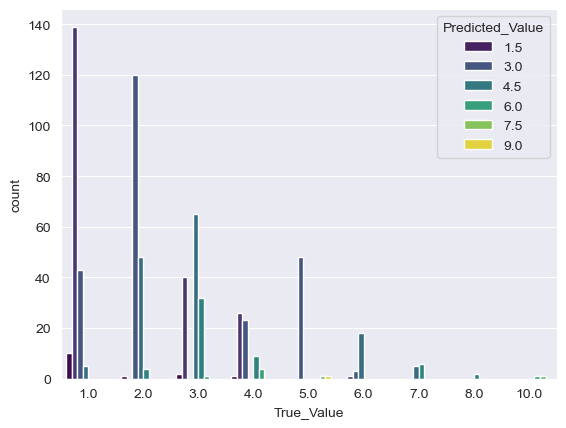

In [183]:
sns.countplot(data=outliers_analysis, x='True_Value', hue='Predicted_Value',palette='viridis')
plt.savefig('outliers_anxiety_stress_level_distribution.png', dpi=300)

In [168]:
import joblib

joblib.dump(best_model_obj, 'results/regression/model/best_regression_model.pkl')

['best_regression_model.pkl']

In [182]:
len(outliers_analysis[outliers_analysis['True_Value']== 3])

140

In [197]:
outliers_analysis[(outliers_analysis['True_Value']== 1) & (outliers_analysis['Predicted_Value'] == 2)]

,True_Value,Predicted_Value,Residual,APE_%,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),...,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10)
3984,1.0,2.0,1.0,79.0,23.0,Female,Student,7.0,1.0,290.0,...,No,1.0,74.0,18.0,2.0,No,Yes,0.0,No,9.0
4209,1.0,2.0,1.0,84.0,38.0,Other,Musician,7.0,1.0,261.0,...,Yes,1.0,81.0,23.0,2.0,No,No,4.0,No,9.0
6877,1.0,2.0,1.0,142.0,47.0,Other,Other,8.0,1.0,10.0,...,No,4.0,109.0,20.0,5.0,Yes,Yes,0.0,No,6.0
9559,1.0,2.0,1.0,112.0,56.0,Male,Other,7.0,1.0,145.0,...,No,2.0,78.0,22.0,4.0,No,No,3.0,No,9.0
4553,1.0,2.0,1.0,122.0,55.0,Female,Teacher,8.0,4.0,138.0,...,Yes,2.0,111.0,28.0,3.0,Yes,Yes,4.0,No,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,1.0,2.0,1.0,86.0,18.0,Female,Musician,6.0,1.0,271.0,...,No,1.0,65.0,17.0,1.0,No,No,0.0,Yes,4.0
10712,1.0,2.0,1.0,88.0,39.0,Female,Musician,7.0,2.0,109.0,...,Yes,1.0,98.0,16.0,1.0,Yes,No,3.0,No,4.0
1684,1.0,2.0,1.0,124.0,57.0,Male,Teacher,8.0,1.0,242.0,...,Yes,3.0,65.0,17.0,3.0,No,No,1.0,No,3.0
6672,1.0,2.0,1.0,69.0,56.0,Male,Musician,6.0,5.0,156.0,...,No,1.0,117.0,23.0,4.0,No,No,0.0,No,8.0


In [195]:
df[(df['Anxiety Level (1-10)'] == 2)]['Caffeine Intake (mg/day)'].mean()

np.float64(258.5654897494305)